# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [1]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [2]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
#     if prt: print('n,k,cl',n,k,cl)
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [3]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [60]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, uf, config):
    '''Randomly sample a color for each cluster'''
    for root in cluster_constraints:
        max_col = cluster_constraints[root]
        cluster_color = np.random.choice((np.arange(1, max_col+1)))
        for site_str in uf.component(root):
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
        partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for root in cluster_constraints:
            cluster_color = color_arr[i]
            for site_str in uf.component(root):
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        if prt: print('Case with field and gamma > 0 or case with gamma = 0')
            
        '''Randomly sample a color for each cluster'''
        config = brute_force_sample (cluster_constraints, uf, config)
            
    return config, uf, cluster_constraints


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [62]:
only_averages = False
prt = True
N, no_cols = 4, 16
gamma = 2    # strength of preference for low no. of cols
J = 1        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)
curr_params = {}
curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
param_name = "Alpha"

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)
for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

session.terminate()

lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
edge probabilities: [0.86466472 0.13533528]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[ 6  5 14 10]
 [ 1 16  7  5]
 [12  6  7 12]
 [ 9 11  7  8]]

-------------------- iter 0 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 11
assigned no. cols (eta_lambda): 12
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 1  1  1  1]
 [ 1  1  1  1]
 [ 1  1  0  1]
 [-1 -1 -1 -1]]



exact number of colors to use in configuration:
3
partition_dict {(2, 0, 1): 10, (1, 2, 0): 15}
partition_p: [10, 15]
partition_p: [0.4, 0.6]
chosen partition:
(2, 0, 1)
chosen partition:
[1, 1, 3]
colors for clusters:
[12 13 13 13  4]
config:
[[12 12 12 13]
 [12 12 13 13]
 [12 13  4 13]
 [13 13 13 13]]

-------------------- iter 13 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  1  0]
 [ 0  1  1  0]
 [ 1  0  1  0]
 [-1 -1 -1 -1]]

[[ 0  0  1 -1]
 [ 0  1  0 -1]
 [ 1  1  1 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned m

partition_dict {(1, 0, 1): 4, (0, 2, 0): 3}
partition_p: [4, 3]
partition_p: [0.5714285714285714, 0.42857142857142855]
chosen partition:
(1, 0, 1)
chosen partition:
[1, 3]
colors for clusters:
[15 15  1 15]
config:
[[15 15 15 15]
 [15 15 15 15]
 [15 15 15  1]
 [15 15 15 15]]

-------------------- iter 25 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  1  0  0]
 [ 0  0  0  1]
 [ 0  1  0  1]
 [-1 -1 -1 -1]]

[[ 0  1  0 -1]
 [ 0  0  0 -1]
 [ 0  1  1 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 1

[[ 0  1  0  0]
 [ 1  1  0  0]
 [ 0  1  0  0]
 [-1 -1 -1 -1]]

[[ 0  1  1 -1]
 [ 1  0  0 -1]
 [ 0  1  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 2 2]
 [1 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Case with no field and gamma > 0
prob_k: [16, 240, 0]
prob_k: [0.0625 0.9375 0.    ]
exact number of colors to use in configuration:
2
partition_dict {(2,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(2,)
chosen partition:
[1, 1]
colors for clusters:
[8 6]
config:
[[8 8 6 6]
 [8 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]

-------------------- iter 39 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4

config:
[[8 1 1 8]
 [8 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]

-------------------- iter 47 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  1  1  1]
 [ 1  0  0  0]
 [ 0  1  1  0]
 [-1 -1 -1 -1]]

[[ 1  0  1 -1]
 [ 1  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 2 2 3]
 [1 4 4 4]
 [4 4 4 4]
 [4 4 4 4]]
Case with no field and gamma > 0
prob_k: [16, 1680]
prob_k: [0.00943396 0.99056604]
ex

assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  1]
 [ 0  0  1  1]
 [ 1  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  1  1 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):
[[1 1 1 2]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Case with no field and gamma > 0
prob_k: [16, 240]
prob_k: [0.0625 0.9375]
exact number of colors to use in configuration:
2
partition_dict {(2,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(2,)
chosen partition:
[1, 1]
colors for clusters:
[14  8]
config:
[[14 14 14  8]
 [14 14 14 14]
 [14 14 14 14]
 [14 14 14 14]]

-------------------- iter 63 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92

partition_dict {(2,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(2,)
chosen partition:
[1, 1]
colors for clusters:
[3 2]
config:
[[3 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]

-------------------- iter 78 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 1  0  0  1]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 1  0  0 -1]
 [ 0  1  0 -1]
 [ 0  0  0 -1]
 [ 0  1  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_ed

partition_dict {(1,): 1}
partition_p: [1]
partition_p: [1.0]
chosen partition:
(1,)
chosen partition:
[1]
colors for clusters:
[5]
config:
[[5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]
 [5 5 5 5]]

-------------------- iter 92 --------------------
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 9.35762297e-14]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.86466472 0.13533528]
assigned bonds (eta_edges):
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1 -1]]

[[ 0  0  0 -1]
 [ 1  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]]
probabilities for colors (sites): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
assigned max colors (eta_sites):
[[16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]
 [16 16 16 16]]
clusters formed by bonds (eta_edge):


## Full simulation

In [63]:
def init_edge_prob (J):
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    return edge_prob
    
def init_site_prob (alpha, no_cols):
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    return site_prob

def init_lambda_prob (gamma, no_cols):
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    return lambda_prob

In [79]:
def experiment_full_interaction (N, no_cols, gamma=0, J=0, alpha=0, gammas=None, Js=None, alphas=None):
    '''Run simulation for different parameters given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Identify varying parameter'''
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    params = None
    param_name = "None"
    for pms,pname in [(gammas,"Gamma"), (Js,"J"), (alphas,"Alpha")]:
        if pms is not None:
            params = pms
            param_name = pname
    nparam = len(params)
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = init_edge_prob(J)
    site_prob = init_site_prob(alpha, no_cols)   
    lambda_prob = init_lambda_prob(gamma, no_cols)
    print('edge probabilities:', edge_prob)
    print('site probabilities:', site_prob)
    print('lambda probabilities:', lambda_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nparam), np.zeros(nparam)
    std_c, std_s_c = np.zeros(nparam), np.zeros(nparam)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter across the logspace'''
    print('Trying params:', params)
    for iparam in range(nparam):
        
        '''Probabilities for the varying parameter'''
        param = params[iparam]
        print(iparam, ' - param:', param)
        if param_name=="Gamma":
            curr_params['gamma'] = param
            lambda_prob = init_lambda_prob(param, no_cols)
            print('lambda probabilities:', lambda_prob)
        elif param_name=="Alpha":
            curr_params['alpha'] = param
            site_prob = init_site_prob(param, no_cols)
            print('site probabilities:', site_prob)
        elif param_name=="J":
            curr_params['J'] = param
            edge_prob = init_edge_prob(param)
            print('edge probabilities:', edge_prob)
            
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
        print('Final configuration:')
        print(config)
        avg_c[iparam] = tot_c / (mc_steps)
        avg_s_c[iparam] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iparam], avg_s_c[iparam])
        std_c[iparam] = np.std(no_cols_arr)
        std_s_c[iparam] = np.std(no_sites_arr)
        print('Final stds:', std_c[iparam], std_s_c[iparam])
        print('-'*120 + '\n')
    
    f = plt.figure(figsize=(18, 5)); # plot the calculated values 
    
    if param_name=="Gamma":
        my_max_gamma = gammas[-1]
        my_gammas = np.linspace(0, my_max_gamma, num=200)
        z = [np.e**(-my_gamma) for my_gamma in my_gammas]
        y = [E_cols(N*N,zz,C) for zz in z]
        yerr = [np.real(std_cols(N*N,zz,C)) for zz in z]
        plt.errorbar(my_gammas, y, yerr, marker='o', color='black', capsize=3)
    
    plt.errorbar(params, avg_c, std_c, linestyle='solid', capsize=3, marker='o', color='IndianRed')
    
    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(no_cols)
                + ")_J_" + str(J) + "_alpha_" + str(alpha) + "_gamma_" + str(gamma)
                + "_vary_" + param_name + "_.png", format="png")
    
#     plt.show()
    
    return params, avg_c, std_c

## Gamma (lambda / total number of colors)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 1.]
Initial configuration
[[4 4]
 [1 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.6732673267326734 avg. sites per col: 1.6105610561056107
201 num. cols: 2.7064676616915424 avg. sites per col: 1.5804311774461028
301 num. cols: 2.691029900332226 avg. sites per col: 1.6024363233665528
401 num. cols: 2.71072319201995 avg. sites per col: 1.5968412302576906
501 num. cols: 2.720558882235529 avg. sites per col: 1.5874916833000723
601 num. cols: 2.7437603993344424 avg. sites per col: 1.5734886300610178
701 num. cols: 2.7446504992867333 avg. sites per col:

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 1.702970297029703 avg. sites per col: 2.6732673267326734
201 num. cols: 1.8756218905472637 avg. sites per col: 2.4278606965174108
301 num. cols: 1.717607973421927 avg. sites per col: 2.688815060908083
401 num. cols: 1.7007481296758105 avg. sites per col: 2.6982543640897743
501 num. cols: 1.7325349301397206 avg. sites per col: 2.6387225548902173
601 num. cols: 1.7903494176372712 avg. sites per col: 2.536882972823069
701 num. cols: 1.8330955777460771 avg. sites per col: 2.4555397051830674
801 num. cols: 1.7815230961298376 avg. sites per col: 2.5584685809404863
901 num. cols: 1.7291897891231964 avg. sites per col: 2.6526082130965554
1001 num. cols: 1.7072927072927073 avg. sites per col: 2.6959706959706935
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.7044776119402985 2.70116086235489
Final stds: 0.6110343980238973 1.0283562700375362
-------------------

801 num. cols: 1.0699126092384519 avg. sites per col: 3.8601747815230962
901 num. cols: 1.0865704772475027 avg. sites per col: 3.8268590455049947
1001 num. cols: 1.077922077922078 avg. sites per col: 3.844155844155844
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0776119402985074 3.8447761194029852
Final stds: 0.2675599503318992 0.5351199006637984
------------------------------------------------------------------------------------------------------------------------

13  - param: 5.57
lambda probabilities: [9.96189520e-01 3.79596067e-03 1.44644339e-05 5.53272657e-08]
Initial configuration
[[1 1]
 [3 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.0 avg. sites per col: 4.0
201 num. cols: 1.0 avg. sites per col: 4.0
301 num. cols: 1.0 avg. sites per col: 4.0
401 num. cols: 1.0 avg. sites per col: 4.0
501 num. cols: 1.0 av

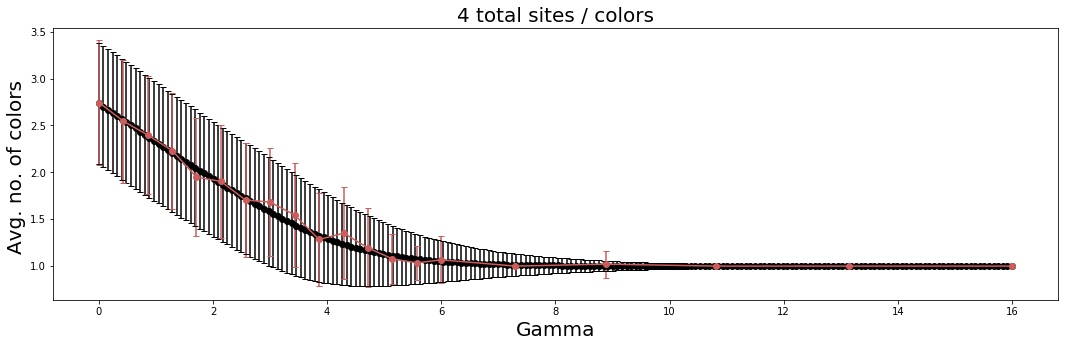

In [106]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (2, 4, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[1 9 6]
 [3 6 5]
 [5 6 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 5.861386138613861 avg. sites per col: 1.5665134370579923
201 num. cols: 5.940298507462686 avg. sites per col: 1.550106609808103
301 num. cols: 5.960132890365449 avg. sites per col: 1.5442097769340302
401 num. cols: 5.975062344139651 avg. sites per col: 1.540639472746705
501 num. cols: 5.966067864271457 avg. sites per col: 1.5441402908468778
601 num. cols: 5.963394342762063 avg. sites per col: 1.5

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 1.8
101 num. cols: 4.1683168316831685 avg. sites per col: 2.3539603960396036
201 num. cols: 3.4378109452736316 avg. sites per col: 2.9679104477611937
301 num. cols: 3.495016611295681 avg. sites per col: 2.8619601328903634
401 num. cols: 3.5885286783042396 avg. sites per col: 2.744139650872815
501 num. cols: 3.662674650698603 avg. sites per col: 2.669076133447387
601 num. cols: 3.5607321131447587 avg. sites per col: 2.7748038982647922
701 num. cols: 3.5805991440798857 avg. sites per col: 2.736743427756262
801 num. cols: 3.606741573033708 avg. sites per col: 2.7010700909577268
901 num. cols: 3.645948945615982 avg. sites per col: 2.6646583161566526
1001 num. cols: 3.6003996003996006 avg. sites per col: 2.701006136720424
Final configuration:
[[1 2 3]
 [3 3 3]
 [3 3 3]]
Final averages: 3.5980099502487564 2.70219616204691
Final stds

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 2.1683168316831685 avg. sites per col: 4.2772277227722775
201 num. cols: 1.5870646766169154 avg. sites per col: 6.626865671641791
301 num. cols: 1.3953488372093024 avg. sites per col: 7.400332225913621
401 num. cols: 1.546134663341646 avg. sites per col: 6.677057356608479
501 num. cols: 1.6367265469061876 avg. sites per col: 6.24251497005988
601 num. cols: 1.838602329450915 avg. sites per col: 5.747920133111481
701 num. cols: 2.0042796005706136 avg. sites per col: 5.355920114122682
801 num. cols: 2.1048689138576777 avg. sites per col: 5.097378277153558
901 num. cols: 2.09322974472808 avg. sites per col: 5.031076581576027
1001 num. cols: 2.0839160839160837 avg. sites per col: 4.978021978021978
Final configuration:
[[1 2 2]
 [2 2 2]
 [2 2 2]]
Final averages: 2.083582089552239 4.976119402985074
Final stds: 0.69

801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 16.0
lambda probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial configuration
[[5 9 6]
 [1 5 5]
 [9 7 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg.

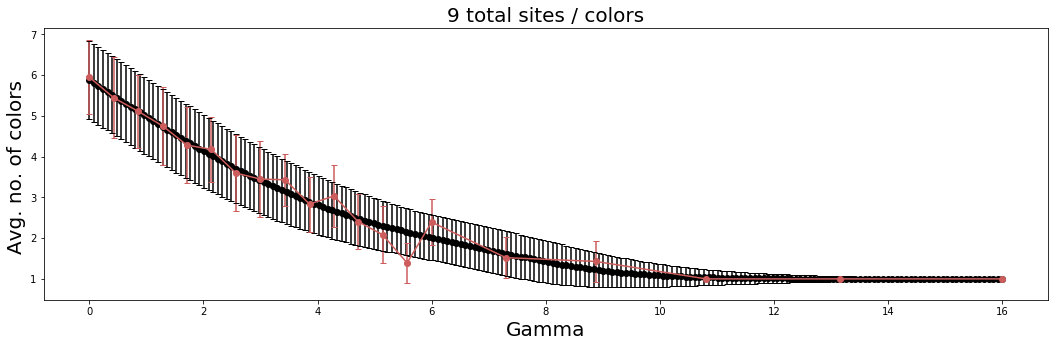

In [107]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (3, 9, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[14 14 13  9]
 [ 2 13 12  5]
 [ 8  5  9 13]
 [14  8 10  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.316831683168317 avg. sites per col: 1.5690861393831672
201 num. cols: 10.303482587064677 avg. sites per col: 1.572786086218921
301 num. cols: 10.305647840531561 avg. sites per col: 1.5729588978758398
401 num. cols: 10.314214463840399 avg. sites per col: 1.5724797231031697
501 num. cols: 10.30538922

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 8.0 avg. sites per col: 2.0
101 num. cols: 7.03960396039604 avg. sites per col: 2.305201948766302
201 num. cols: 6.885572139303482 avg. sites per col: 2.3636105188344
301 num. cols: 7.1096345514950166 avg. sites per col: 2.3028232011620764
401 num. cols: 7.132169576059851 avg. sites per col: 2.2885815763621338
501 num. cols: 6.922155688622754 avg. sites per col: 2.394741829472376
601 num. cols: 6.936772046589018 avg. sites per col: 2.3824755758200062
701 num. cols: 6.950071326676177 avg. sites per col: 2.3706014701735096
801 num. cols: 6.990012484394507 avg. sites per col: 2.355906487741693
901 num. cols: 7.022197558268591 avg. sites per col: 2.340857761057536
1001 num. cols: 7.053946053946054 avg. sites per col: 2.329412002139266
Final configuration:
[[1 2 3 4]
 [5 6 7 7]
 [7 7 7 7]
 [7 7 7 7]]
Final averages: 7.051741293532339 2.329996195070813
Final stds: 1.11404844287443

501 num. cols: 4.894211576846307 avg. sites per col: 3.3832905617336846
601 num. cols: 4.835274542429285 avg. sites per col: 3.414024245305454
701 num. cols: 4.855920114122682 avg. sites per col: 3.3857754228652785
801 num. cols: 4.6716604244694135 avg. sites per col: 3.56566197015635
901 num. cols: 4.513873473917869 avg. sites per col: 3.7319591987738594
1001 num. cols: 4.63036963036963 avg. sites per col: 3.646391703534555
Final configuration:
[[1 2 3 4]
 [5 6 6 6]
 [6 6 6 6]
 [6 6 6 6]]
Final averages: 4.635820895522388 3.642492300402742
Final stds: 1.0616379196313583 0.8690994633015182
------------------------------------------------------------------------------------------------------------------------

11  - param: 4.71
lambda probabilities: [9.90995222e-01 8.92369156e-03 8.03558577e-05 7.23586626e-07
 6.51573663e-09 5.86727592e-11 5.28335146e-13 4.75754048e-15
 4.28405939e-17 3.85770019e-19 3.47377322e-21 3.12805552e-23
 2.81674443e-25 2.53641571e-27 2.28398593e-29 2.07536675e-

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.0 avg. sites per col: 8.0
201 num. cols: 2.0 avg. sites per col: 8.0
301 num. cols: 2.0 avg. sites per col: 8.0
401 num. cols: 2.0 avg. sites per col: 8.0
501 num. cols: 2.0 avg. sites per col: 8.0
601 num. cols: 2.0 avg. sites per col: 8.0
701 num. cols: 2.0 avg. sites per col: 8.0
801 num. cols: 2.0 avg. sites per col: 8.0
901 num. cols: 2.0 avg. sites per col: 8.0
1001 num. cols: 2.042957042957043 avg. sites per col: 7.8854478854478725
Final configuration:
[[1 2 3 3]
 [3 3 3 3]
 [3 3 3 3]
 [3 3 3 3]]
Final averages: 2.0467661691542287 7.875290215588709
Final stds: 0.21113761999432248 0.5630336533181933
------------------------------------------------------------------------------------------------------------------------

17  - param: 10.81
lambda probabilities: [9.99979803e-01 2.01961171e-05 4.07891382

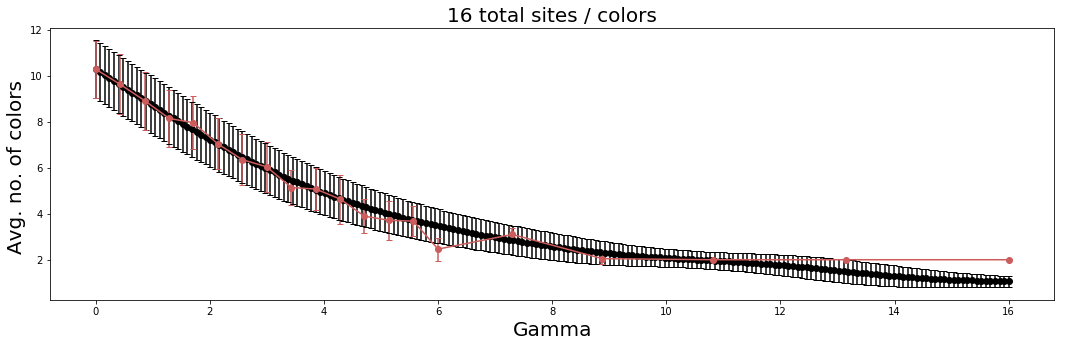

In [108]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (4, 16, gammas=gammas, J=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.43  0.86  1.29  1.71  2.14  2.57  3.    3.43  3.86  4.29  4.71
  5.14  5.57  6.    7.3   8.88 10.81 13.15 16.  ]
0  - param: 0.0
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[ 8 10  2 22 16]
 [ 8  4 21  7 20]
 [ 3 10  1 14 10]
 [ 4  1 21 12 19]
 [17 15  6  9 15]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 15.0 avg. sites per col: 1.6666666666666667
101 num. cols: 16.128712871287128 avg. sites per col: 1.563028442894641
201 num. cols: 16.104477611940297 avg. sites per col: 1.5684146801441528
301 num. cols: 16.023255813953487 avg. sites per col: 1.57

401 num. cols: 12.094763092269327 avg. sites per col: 2.1024804962937567
501 num. cols: 12.165668662674651 avg. sites per col: 2.0869613228278263
601 num. cols: 12.104825291181365 avg. sites per col: 2.0970035627591614
701 num. cols: 11.837375178316691 avg. sites per col: 2.149238455827778
801 num. cols: 11.957553058676654 avg. sites per col: 2.1278234909403597
901 num. cols: 11.81354051054384 avg. sites per col: 2.155219952785558
1001 num. cols: 11.917082917082917 avg. sites per col: 2.135114333522541
Final configuration:
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 12 12 12]
 [12 12 12 12 12]
 [12 12 12 12 12]]
Final averages: 11.917412935323384 2.13490823998945
Final stds: 1.5683896338011059 0.2858567046471276
------------------------------------------------------------------------------------------------------------------------

5  - param: 2.14
lambda probabilities: [8.82345157e-01 1.03812181e-01 1.22140059e-02 1.43703694e-03
 1.69074356e-04 1.98924168e-05 2.34043917e-06 2.75364004

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 8.257425742574258 avg. sites per col: 3.0376787678767876
201 num. cols: 8.228855721393035 avg. sites per col: 3.049040511727078
301 num. cols: 8.813953488372093 avg. sites per col: 2.8739468357408597
401 num. cols: 8.765586034912719 avg. sites per col: 2.8847733383269625
501 num. cols: 8.47305389221557 avg. sites per col: 2.997771246274258
601 num. cols: 8.194675540765392 avg. sites per col: 3.113277575632015
701 num. cols: 8.049928673323823 avg. sites per col: 3.167171135252471
801 num. cols: 8.00374531835206 avg. sites per col: 3.1797411736550467
901 num. cols: 7.739178690344062 avg. sites per col: 3.3343996766582884
1001 num. cols: 7.62037962037962 avg. sites per col: 3.4037970576432177
Final configuration:
[[1 2 3 4 5]
 [6 7 8 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 7.

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.107231920199501 avg. sites per col: 6.115960099750623
501 num. cols: 4.285429141716567 avg. sites per col: 5.893213572854291
601 num. cols: 4.404326123128119 avg. sites per col: 5.74459234608985
701 num. cols: 4.489300998573467 avg. sites per col: 5.638373751783167
801 num. cols: 4.5530586766541825 avg. sites per col: 5.558676654182272
901 num. cols: 4.602663706992231 avg. sites per col: 5.496670366259711
1001 num. cols: 4.642357642357642 avg. sites per col: 5.447052947052947
Final configuration:
[[1 2 3 4 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]
 [5 5 5 5 5]]
Final averages: 4.643781094527363 5.445273631840796
Final stds: 0.4788809840205742 0.5986012300257177
--------------

801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[1 2 3 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]
 [4 4 4 4 4]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



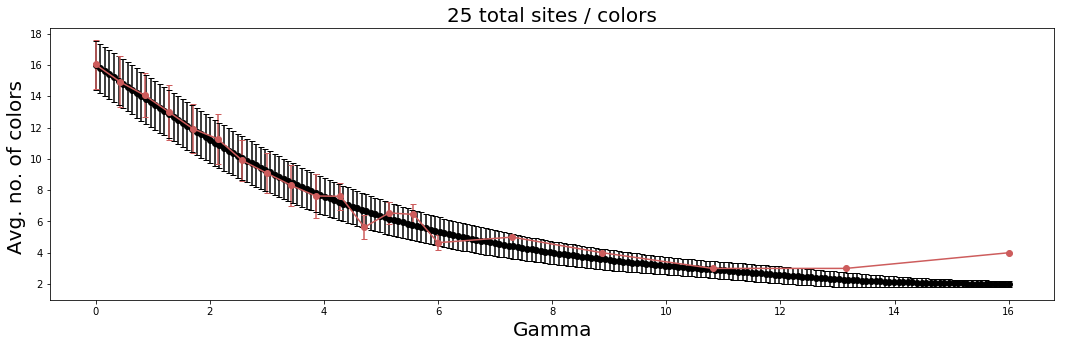

In [109]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = True
prt = False
ngamma = 20
gammas = np.linspace(0, 6, num=ngamma-6, endpoint=False)
gammas = np.append(gammas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (5, 25, gammas=gammas, J=0, alpha=0)

## J (edges / neighbor interaction)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[2 3]
 [1 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 2.712871287128713 avg. sites per col: 1.567656765676568
201 num. cols: 2.7213930348258706 avg. sites per col: 1.5671641791044773
301 num. cols: 2.7475083056478407 avg. sites per col: 1.547065337763008
401 num. cols: 2.7306733167082293 avg. sites per col: 1.5577722360764747
501 num. cols: 2.7285429141716566 avg. sites per col: 1.5582168995342687
601 num. cols: 2.7171381031613975 avg. sites per col: 1.5734886300610156
701 num. cols: 2.7061340941512126 avg. sites per col: 1.58487

301 num. cols: 2.006644518272425 avg. sites per col: 2.333333333333334
401 num. cols: 1.9551122194513715 avg. sites per col: 2.403158769742313
501 num. cols: 1.8882235528942115 avg. sites per col: 2.5009980039920165
601 num. cols: 1.8868552412645592 avg. sites per col: 2.504159733777036
701 num. cols: 1.897289586305278 avg. sites per col: 2.478364241559673
801 num. cols: 1.9188514357053683 avg. sites per col: 2.451518934664996
901 num. cols: 1.925638179800222 avg. sites per col: 2.4347021827598927
1001 num. cols: 1.925074925074925 avg. sites per col: 2.4368964368964368
Final configuration:
[[3 4]
 [1 1]]
Final averages: 1.9283582089552238 2.4331674958540632
Final stds: 0.7185126920255251 1.0272597278715714
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
Initial configuration
[[1 1]
 [3 4]]
equilibration step: 0
equilibration step: 1000
equilibration step

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.0 avg. sites per col: 4.0
201 num. cols: 1.0 avg. sites per col: 4.0
301 num. cols: 1.043189368770764 avg. sites per col: 3.913621262458472
401 num. cols: 1.054862842892768 avg. sites per col: 3.890274314214464
501 num. cols: 1.0638722554890219 avg. sites per col: 3.8722554890219563
601 num. cols: 1.08153078202995 avg. sites per col: 3.8369384359401
701 num. cols: 1.0898716119828815 avg. sites per col: 3.8221588207322874
801 num. cols: 1.1123595505617978 avg. sites per col: 3.781939242613401
901 num. cols: 1.1076581576026636 avg. sites per col: 3.7906030336662973
1001 num. cols: 1.103896103896104 avg. sites per col: 3.7988677988677995
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.1034825870646767 3.79966832504146
Final stds: 0.32050614657958926 0.6077624827895107
-----------------------------------

301 num. cols: 1.0 avg. sites per col: 4.0
401 num. cols: 1.0 avg. sites per col: 4.0
501 num. cols: 1.0 avg. sites per col: 4.0
601 num. cols: 1.0099833610648918 avg. sites per col: 3.9800332778702163
701 num. cols: 1.0156918687589158 avg. sites per col: 3.9686162624821684
801 num. cols: 1.013732833957553 avg. sites per col: 3.972534332084894
901 num. cols: 1.0122086570477247 avg. sites per col: 3.9755826859045507
1001 num. cols: 1.010989010989011 avg. sites per col: 3.978021978021978
Final configuration:
[[2 2]
 [2 2]]
Final averages: 1.0109452736318407 3.9781094527363186
Final stds: 0.1040455410719985 0.208091082143997
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[1 4]
 [4 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 

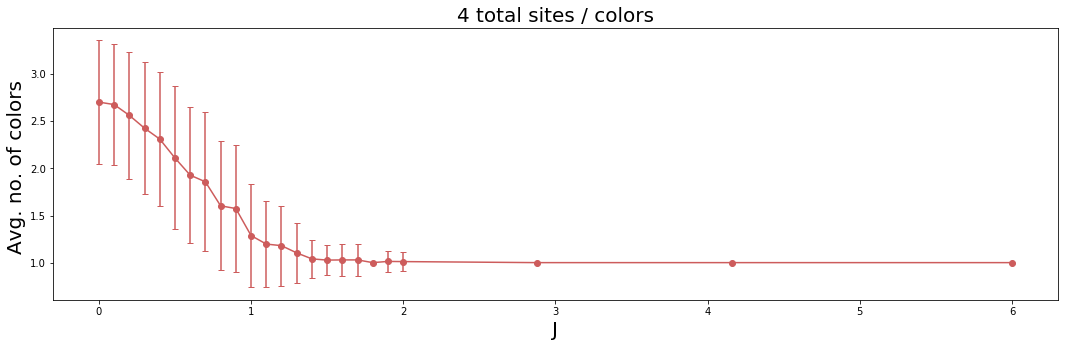

In [65]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (2, 4, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[1 9 5]
 [9 9 6]
 [4 6 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 1.5
101 num. cols: 5.861386138613861 avg. sites per col: 1.5829561527581335
201 num. cols: 5.830845771144278 avg. sites per col: 1.5871179815209677
301 num. cols: 5.857142857142857 avg. sites per col: 1.5819886093972482
401 num. cols: 5.865336658354114 avg. sites per col: 1.5770395439971496
501 num. cols: 5.874251497005988 avg. sites per col: 1.5754562303963497
601 num. cols: 5.898502495840266 avg. sites per col: 1.567910625148562
701 num. cols: 5.88587

equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 4.673267326732673 avg. sites per col: 2.06881188118812
201 num. cols: 4.676616915422885 avg. sites per col: 2.0573560767590635
301 num. cols: 4.59468438538206 avg. sites per col: 2.116516373991457
401 num. cols: 4.620947630922693 avg. sites per col: 2.083808336302098
501 num. cols: 4.668662674650698 avg. sites per col: 2.054961505560302
601 num. cols: 4.700499168053245 avg. sites per col: 2.0419538863798348
701 num. cols: 4.706134094151213 avg. sites per col: 2.0432647238638584
801 num. cols: 4.694132334581773 avg. sites per col: 2.053317281968957
901 num. cols: 4.748057713651498 avg. sites per col: 2.025285397177727
1001 num. cols: 4.781218781218781 avg. sites per col: 2.007756529185088
Final configuration:
[[3 4 4]
 [7 1 6]
 [2 7 9]]
Final averages: 4.7890547263681595 2.0050959488272793
Final stds: 1.1238170572204143 0.5792478724244312
--------------------------------------------

801 num. cols: 1.564294631710362 avg. sites per col: 6.8737827715355815
901 num. cols: 1.5948945615982242 avg. sites per col: 6.810932297447281
1001 num. cols: 1.6173826173826173 avg. sites per col: 6.711938061938063
Final configuration:
[[7 7 7]
 [7 7 7]
 [7 7 7]]
Final averages: 1.6149253731343283 6.721044776119403
Final stds: 0.7816146824642987 2.5242313056774854
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[9 4 9]
 [1 1 3]
 [4 9 6]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.4158415841584158 avg. sites per col: 7.421287128712871
201 num. cols: 1.4029850746268657 avg. sites per col: 7.438059701492537
301 num. cols: 1.302325581395349 avg. sites per col: 7.80747508305

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg. sites per col: 9.0
701 num. cols: 1.0 avg. sites per col: 9.0
801 num. cols: 1.0262172284644195 avg. sites per col: 8.882022471910112
901 num. cols: 1.02330743618202 avg. sites per col: 8.89511653718091
1001 num. cols: 1.020979020979021 avg. sites per col: 8.905594405594405
Final configuration:
[[3 3 3]
 [3 3 3]
 [3 3 3]]
Final averages: 1.0208955223880598 8.905970149253731
Final stds: 0.14303460956072764 0.6436557430232743
------------------------------------------------------------------------------------------------------------------------

20  - param: 2.0
edge probabilities: [0.98168

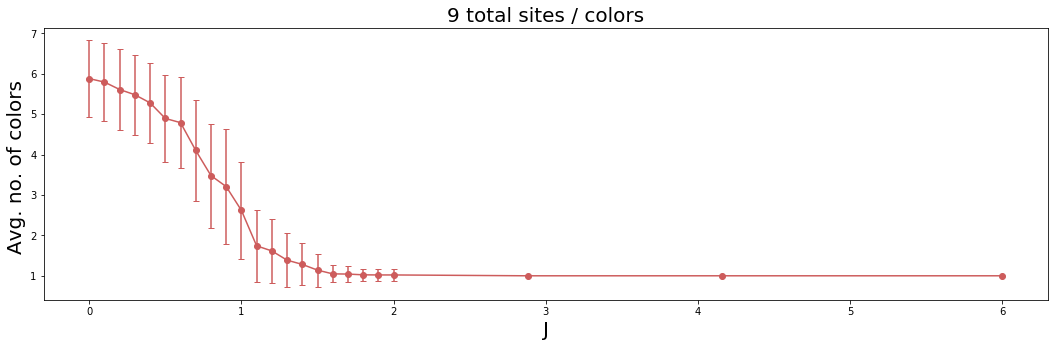

In [67]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (3, 9, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[13  6  9  7]
 [ 9  6  5  2]
 [ 7 12  3 12]
 [12 15  5 11]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 1.4545454545454546
101 num. cols: 10.257425742574258 avg. sites per col: 1.5894952132575884
201 num. cols: 10.228855721393035 avg. sites per col: 1.5937641131670974
301 num. cols: 10.212624584717608 avg. sites per col: 1.5932668291472274
401 num. cols: 10.239401496259351 avg. sites per col: 1.5885016064567252
501 num. cols: 10.241516966067865 avg. sites per col: 1.58737682809540

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 8.673267326732674 avg. sites per col: 1.8921492149214905
201 num. cols: 8.91044776119403 avg. sites per col: 1.8362875377800743
301 num. cols: 8.787375415282392 avg. sites per col: 1.8659226340289474
401 num. cols: 8.775561097256858 avg. sites per col: 1.8725696581058253
501 num. cols: 8.7624750499002 avg. sites per col: 1.8779191976796876
601 num. cols: 8.743760399334443 avg. sites per col: 1.8830677180094932
701 num. cols: 8.78601997146933 avg. sites per col: 1.8735793292141463
801 num. cols: 8.852684144818976 avg. sites per col: 1.8582272215231088
901 num. cols: 8.821309655937847 avg. sites per col: 1.8662850529665236
1001 num. cols: 8.836163836163836 avg. sites per col: 1.8618128236509899
Final configuration:
[[12  7 14  6]
 [ 5  7  7  6]
 [12  3 11  3]
 [12  3  8 11]]
Final averages: 8.83

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.6336633663366336 avg. sites per col: 10.983498349834983
201 num. cols: 1.9104477611940298 avg. sites per col: 9.59867330016583
301 num. cols: 1.7906976744186047 avg. sites per col: 10.387596899224798
401 num. cols: 1.6783042394014962 avg. sites per col: 11.175394846217786
501 num. cols: 2.063872255489022 avg. sites per col: 10.008022051135802
601 num. cols: 1.923460898502496 avg. sites per col: 10.76542270818475
701 num. cols: 1.9400855920114122 avg. sites per col: 10.649004823041887
801 num. cols: 2.0724094881398254 avg. sites per col: 10.24276796861064
901 num. cols: 1.9966703662597114 avg. sites per col: 10.55914592251993
1001 num. cols: 2.097902097902098 avg. sites per col: 10.1114123971267
Final configuration:
[[ 8  5  8  7]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [16  8  8  8]]
Final averages: 2.1044776119402986 10.088415067519561
F

401 num. cols: 1.0498753117206983 avg. sites per col: 15.600997506234414
501 num. cols: 1.0399201596806387 avg. sites per col: 15.68063872255489
601 num. cols: 1.0332778702163061 avg. sites per col: 15.733777038269551
701 num. cols: 1.028530670470756 avg. sites per col: 15.771754636233952
801 num. cols: 1.024968789013733 avg. sites per col: 15.800249687890137
901 num. cols: 1.04661487236404 avg. sites per col: 15.633000369959305
1001 num. cols: 1.0419580419580419 avg. sites per col: 15.66966366966367
Final configuration:
[[2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]
 [2 2 2 2]]
Final averages: 1.0417910447761194 15.670978441127696
Final stds: 0.20502342086669895 1.597566967163238
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14 10 15  4]
 [ 3  5  6  3]
 [ 2  3  1 13]
 [10 12 13  3]]
equilibration step: 0
equilibration step: 1000
equilibrati

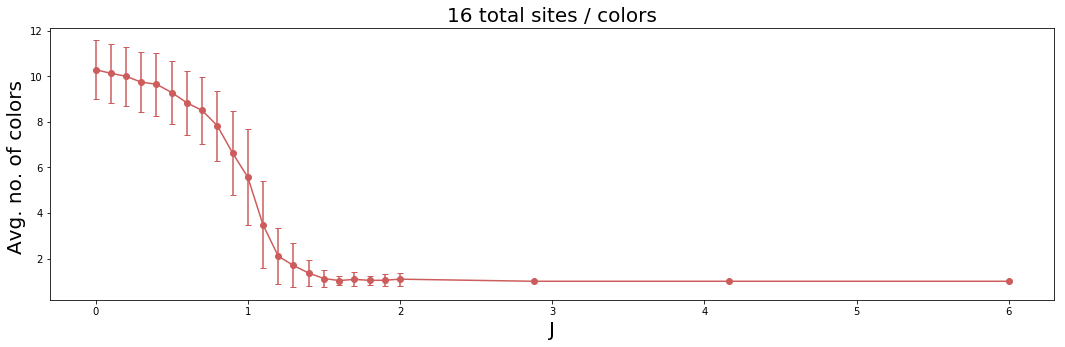

In [31]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (4, 16, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[19 22  8  3 12]
 [ 3 16 25 25 18]
 [10 18 23 22  7]
 [ 3 24 13  6 25]
 [22  6 14 24 19]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 15.841584158415841 avg. sites per col: 1.5936414049325187
201 num. cols: 15.965174129353233 avg. sites per col: 1.5822768647124048
301 num. cols: 15.976744186046512 avg. sites per col: 1.5810580597558774
401 num. cols: 15.88778054862843 avg. sites per col: 1.59

501 num. cols: 15.029940119760479 avg. sites per col: 1.6853936463730055
601 num. cols: 14.958402662229616 avg. sites per col: 1.694641100285333
701 num. cols: 14.968616262482168 avg. sites per col: 1.693977578137151
801 num. cols: 14.935081148564295 avg. sites per col: 1.6980643594543907
901 num. cols: 14.937846836847946 avg. sites per col: 1.6977729128948724
1001 num. cols: 14.918081918081919 avg. sites per col: 1.7008015558004674
Final configuration:
[[ 8  8  9 22 10]
 [ 4  8  3 13  8]
 [18 21  4  2 24]
 [ 4 16 17 24 24]
 [15  6  3 17 20]]
Final averages: 14.917412935323384 1.7008171817041573
Final stds: 1.7704442688450852 0.21350925635242823
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[15 11 24  6 21]
 [21 13 20 25  6]
 [15  3 16  3 17]
 [ 7  3 13  8 15]
 [17  2  9 20 14]]
equilibration step: 0
equilibration step: 1000
equi

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 4.910891089108911 avg. sites per col: 5.519801980198016
201 num. cols: 5.666666666666667 avg. sites per col: 4.787570086077542
301 num. cols: 5.760797342192691 avg. sites per col: 4.761772926224756
401 num. cols: 5.453865336658354 avg. sites per col: 5.359574098663875
501 num. cols: 4.860279441117765 avg. sites per col: 6.441329102257253
601 num. cols: 4.324459234608985 avg. sites per col: 8.361102407483447
701 num. cols: 4.185449358059914 avg. sites per col: 8.78255373173348
801 num. cols: 4.0 avg. sites per col: 8.93142342814626
901 num. cols: 4.013318534961154 avg. sites per col: 8.904704248766386
1001 num. cols: 4.341658341658341 avg. sites per col: 8.380455222987669
Final configuration:
[[13  7  7 14 24]
 [25 15 15 15 10]
 [10 10 15 15 15]
 [10 10 15 15 15]
 [19 17 15 15 15]]
Final averages: 4.353233830845771 8.36111739283379
Final stds: 

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.8217821782178218 avg. sites per col: 16.79042904290427
201 num. cols: 1.4825870646766168 avg. sites per col: 20.004145936981747
301 num. cols: 1.3787375415282392 avg. sites per col: 20.9579180509413
401 num. cols: 1.28428927680798 avg. sites per col: 21.965918536990852
501 num. cols: 1.375249500998004 avg. sites per col: 21.074517631403882
601 num. cols: 1.377703826955075 avg. sites per col: 20.971991125901297
701 num. cols: 1.3366619115549216 avg. sites per col: 21.386115073704254
801 num. cols: 1.2946317103620475 avg. sites per col: 21.83728672492719
901 num. cols: 1.2619311875693673 avg. sites per col: 22.188309285978555
1001 num. cols: 1.2357642357642358 avg. sites per col: 22.469197469197482
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]

701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



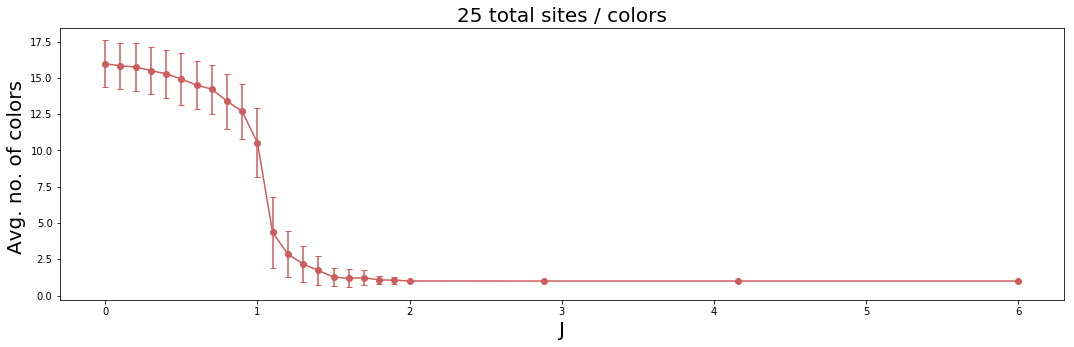

In [32]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (5, 25, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[ 1 23 32 35 28  6]
 [17  8  2  6 21  8]
 [31 23  8 13 14 21]
 [ 1 36 31 32 15  2]
 [21 25 19 11 35  4]
 [16 25  9  7 12 27]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 23.0 avg. sites per col: 1.565217391304348
101 num. cols: 23.10891089108911 avg. sites per col: 1.5666897771327155
201 num. cols: 23.149253731343283 avg. sites per col: 1.5651268680012826
301 num. cols: 23.089700996677

equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 21.0 avg. sites per col: 1.7142857142857142
101 num. cols: 21.900990099009903 avg. sites per col: 1.6598448280376867
201 num. cols: 22.054726368159205 avg. sites per col: 1.6459781190109901
301 num. cols: 22.07641196013289 avg. sites per col: 1.6452630296895603
401 num. cols: 21.982543640897756 avg. sites per col: 1.6525393412312648
501 num. cols: 22.013972055888225 avg. sites per col: 1.6496022723478947
601 num. cols: 22.071547420965057 avg. sites per col: 1.6449163143710834
701 num. cols: 22.01426533523538 avg. sites per col: 1.6498030218390756
801 num. cols: 21.976279650436954 avg. sites per col: 1.6522601433051585
901 num. cols: 21.95449500554939 avg. sites per col: 1.6536569133971435
1001 num. cols: 21.883116883116884 avg. sites per col: 1.6592630050445996
Final configuration:
[[ 1 14 26 32 35  5]
 [20 28 31 32 12  9]
 [19  7 14  5 26 13]
 [ 4 26 14  7  7 13]
 [19  4 13

801 num. cols: 18.57178526841448 avg. sites per col: 1.9713578577495368
901 num. cols: 18.638179800221977 avg. sites per col: 1.9627799513104727
1001 num. cols: 18.645354645354644 avg. sites per col: 1.9612001457690433
Final configuration:
[[36 10 15 32 22 34]
 [36 22  2 22 14 26]
 [31 19  6  5  8 26]
 [20 28 27 26 11  4]
 [10 35 34 24 36 12]
 [34 20  7 27  1 11]]
Final averages: 18.65870646766169 1.9599266477410424
Final stds: 2.3024832621639693 0.25157143974702484
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[26 31 32  7 11 15]
 [31 25 19  2  8  4]
 [31 32 18 31  3  3]
 [ 8 19 15 30 33 33]
 [15 21 12  5 26 27]
 [30 23 33  9 27  5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 17.0 avg. sites per col: 2.1176470588

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0792079207920793 avg. sites per col: 34.57425742574257
201 num. cols: 1.4378109452736318 avg. sites per col: 28.29850746268657
301 num. cols: 1.2923588039867109 avg. sites per col: 30.857142857142858
401 num. cols: 1.3216957605985038 avg. sites per col: 30.299251870324188
501 num. cols: 1.2574850299401197 avg. sites per col: 31.437125748502993
601 num. cols: 1.2146422628951747 avg. sites per col: 32.196339434276204
701 num. cols: 1.2482168330955778 avg. sites per col: 31.823109843081312
801 num. cols: 1.4132334581772783 avg. sites per col: 29.692883895131086
901 num. cols: 1.3984461709211986 avg. sites per col: 29.83351831298557
1001 num. cols: 1.3746253746253747 avg. sites per col: 30.161838161838162
Final configuration:
[[12 12 12 12 12 12]
 [12 12 12 12 12 12]
 [12 12 12 12 12 12]
 [12 12 12 12 12 12]


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 36.0
101 num. cols: 1.0 avg. sites per col: 36.0
201 num. cols: 1.0 avg. sites per col: 36.0
301 num. cols: 1.0 avg. sites per col: 36.0
401 num. cols: 1.0 avg. sites per col: 36.0
501 num. cols: 1.0 avg. sites per col: 36.0
601 num. cols: 1.0 avg. sites per col: 36.0
701 num. cols: 1.0 avg. sites per col: 36.0
801 num. cols: 1.0 avg. sites per col: 36.0
901 num. cols: 1.0 avg. sites per col: 36.0
1001 num. cols: 1.0 avg. sites per col: 36.0
Final configuration:
[[25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]
 [25 25 25 25 25 25]]
Final averages: 1.0 36.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial 

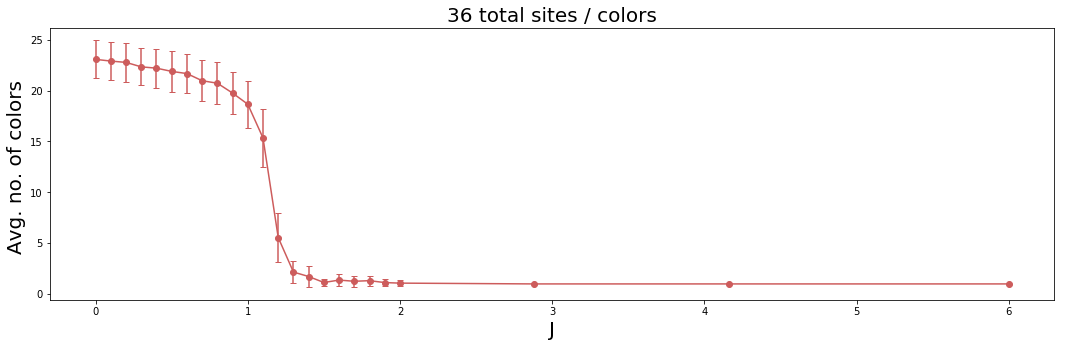

In [70]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (6, 36, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[33  6 14 25  9  3 16]
 [46 37 15  1 47 27 35]
 [ 7 46 39 30 17 21 17]
 [31 48 12 26 30 19 16]
 [47 44 13  3  2 28 21]
 [22 47 21 26 34  4 41]
 [14 30 40  9 45 31 40]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 33.0 avg. sites per col: 1.4848484848484849
101 num. cols: 31.742574257425744 avg. sites per col

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 31.0 avg. sites per col: 1.5806451612903225
101 num. cols: 30.14851485148515 avg. sites per col: 1.6332820727646604
201 num. cols: 30.208955223880597 avg. sites per col: 1.6306188987621741
301 num. cols: 30.308970099667775 avg. sites per col: 1.6255202497213352
401 num. cols: 30.25436408977556 avg. sites per col: 1.6286545118945448
501 num. cols: 30.213572854291417 avg. sites per col: 1.6308727454009564
601 num. cols: 30.204658901830282 avg. sites per col: 1.6315472117162777
701 num. cols: 30.225392296718972 avg. sites per col: 1.6303473255000065
801 num. cols: 30.146067415730336 avg. sites per col: 1.6350825304238212
901 num. cols: 30.0976692563818 avg. sites per col: 1.6375332919230625
1001 num. cols: 30.142857142857142 avg. sites per col: 1.6348805955050796
Final configuration:
[[27 35 35  2 14 25 14]
 [19 16 33 22  1 40 26]
 [20  8 11  9 17 23 23

301 num. cols: 26.737541528239202 avg. sites per col: 1.848202832556432
401 num. cols: 26.531172069825438 avg. sites per col: 1.8639184243587839
501 num. cols: 26.457085828343313 avg. sites per col: 1.8694903308044577
601 num. cols: 26.665557404326123 avg. sites per col: 1.8555866435479542
701 num. cols: 26.5848787446505 avg. sites per col: 1.8613492841701313
801 num. cols: 26.690387016229714 avg. sites per col: 1.853500385459734
901 num. cols: 26.801331853496116 avg. sites per col: 1.8455561416478257
1001 num. cols: 26.747252747252748 avg. sites per col: 1.8489653092215539
Final configuration:
[[47 30 38 29 15 35 35]
 [19 48 41 41 15 11 39]
 [45 14  9 44 44 35 25]
 [42 14  1  8 12 12 12]
 [ 5 15 26 16 38 12  4]
 [14 40 18 39 25 12 24]
 [14  1  8 38 31 20 41]]
Final averages: 26.756218905472636 1.8483607199825158
Final stds: 2.53164521494797 0.18164338440900588
------------------------------------------------------------------------------------------------------------------------

11  

701 num. cols: 2.289586305278174 avg. sites per col: 27.41716595339995
801 num. cols: 2.1897627965043696 avg. sites per col: 28.63329171868502
901 num. cols: 2.150943396226415 avg. sites per col: 28.609618941916427
1001 num. cols: 2.1358641358641357 avg. sites per col: 28.199067599067632
Final configuration:
[[35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35]
 [35 35 35 35 35 35 35]
 [35 35 35 35 35 35 43]]
Final averages: 2.135323383084577 28.184344941956915
Final stds: 0.9397766326654315 13.161879887454658
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[45 45 46 24  9 39 39]
 [ 1 35 31 20 14 34  4]
 [37 43 19  5  8 24 47]
 [34 45 29 43 36 49  4]
 [16 34  3 24 44 19 42]
 [49 26 34 33 16 21 41]
 [35 13 40  2 44 12  6]]
equilibration step: 0
equilibration step: 1000

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 49.0
101 num. cols: 1.0 avg. sites per col: 49.0
201 num. cols: 1.0 avg. sites per col: 49.0
301 num. cols: 1.0 avg. sites per col: 49.0
401 num. cols: 1.0 avg. sites per col: 49.0
501 num. cols: 1.0 avg. sites per col: 49.0
601 num. cols: 1.0 avg. sites per col: 49.0
701 num. cols: 1.0 avg. sites per col: 49.0
801 num. cols: 1.0 avg. sites per col: 49.0
901 num. cols: 1.0 avg. sites per col: 49.0
1001 num. cols: 1.0 avg. sites per col: 49.0
Final configuration:
[[14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]
 [14 14 14 14 14 14 14]]
Final averages: 1.0 49.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilitie

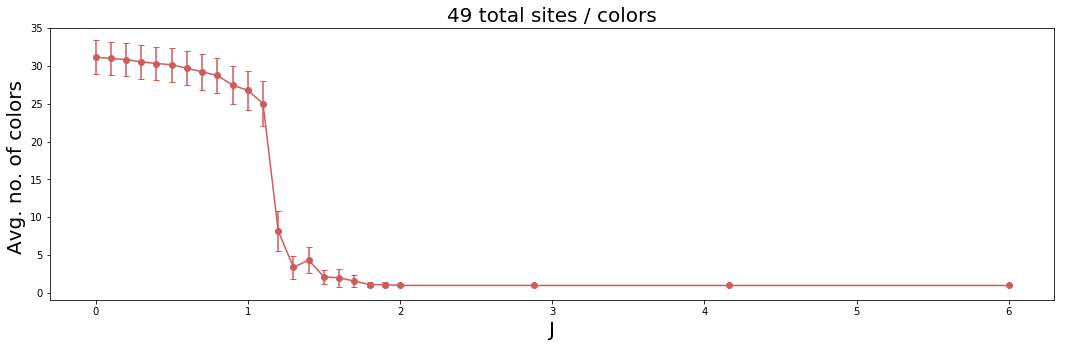

In [71]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (7, 49, Js=Js, gamma=0, alpha=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[21 23 65 37 36 55 99 98 56 53]
 [93 56 68 67 35 48 70 84 12 90]
 [64 33 53 84 63 48 11 70 93 91]
 [91 63 80  7  4

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 70.0 avg. sites per col: 1.4285714285714286
101 num. cols: 62.16831683168317 avg. sites per col: 1.6127893958642499
201 num. cols: 62.45771144278607 avg. sites per col: 1.6051918211997376
301 num. cols: 62.51495016611295 avg. sites per col: 1.6040304937499532
401 num. cols: 62.31172069825436 avg. sites per col: 1.6094221011451166
501 num. cols: 62.30538922155689 avg. sites per col: 1.6096518807294231
601 num. cols: 62.29450915141431 avg. sites per col: 1.609947278868978
701 num. cols: 62.37660485021398 avg. sites per col: 1.607720436003894
801 num. cols: 62.438202247191015 avg. sites per col: 1.6060931491050612
901 num. cols: 62.426193118756935 avg. sites per col: 1.6064361163360745
1001 num. cols: 62.43256743256743 avg. sites per col: 1.6061730122389972
Final configuration:
[[ 47  78  71  32  12  30  55  55  90  34]
 [ 53  46   6  77  14  84  20  94

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 66.0 avg. sites per col: 1.5151515151515151
101 num. cols: 61.56435643564357 avg. sites per col: 1.6281327235998873
201 num. cols: 60.64179104477612 avg. sites per col: 1.6541121043654656
301 num. cols: 61.093023255813954 avg. sites per col: 1.6415757684367254
401 num. cols: 60.952618453865334 avg. sites per col: 1.6454578131189916
501 num. cols: 60.880239520958085 avg. sites per col: 1.647649850170645
601 num. cols: 60.963394342762065 avg. sites per col: 1.6453336813320802
701 num. cols: 60.98145506419401 avg. sites per col: 1.644915278875593
801 num. cols: 61.03121098626717 avg. sites per col: 1.6435687925712563
901 num. cols: 61.067702552719204 avg. sites per col: 1.6424552736531215
1001 num. cols: 61.044955044955046 avg. sites per col: 1.6430221109528014
Final configuration:
[[ 80  36  13  66  47  82  84  35  60  81]
 [ 83  37   6   6  76  24  13

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 58.0 avg. sites per col: 1.7241379310344827
101 num. cols: 57.46534653465346 avg. sites per col: 1.7456506598194335
201 num. cols: 56.67164179104478 avg. sites per col: 1.7707730935461745
301 num. cols: 56.59468438538206 avg. sites per col: 1.7732939282433422
401 num. cols: 56.44139650872818 avg. sites per col: 1.778382732728759
501 num. cols: 56.395209580838326 avg. sites per col: 1.779940933975146
601 num. cols: 56.65557404326123 avg. sites per col: 1.7717379464635044
701 num. cols: 56.29957203994294 avg. sites per col: 1.7836046092848312
801 num. cols: 56.0936329588015 avg. sites per col: 1.790341394747849
901 num. cols: 56.03218645948946 avg. sites per col: 1.7921047540921147
1001 num. cols: 56.154845154845155 avg. sites per col: 1.788054795004356
Final configuration:
[[ 88   3  11  81  14   9   6  96  40  52]
 [ 88  36  40  81  60  16  22  89  5

101 num. cols: 1.7524752475247525 avg. sites per col: 62.37623762376238
201 num. cols: 1.5024875621890548 avg. sites per col: 74.87562189054727
301 num. cols: 1.6179401993355482 avg. sites per col: 69.1029900332226
401 num. cols: 1.4912718204488777 avg. sites per col: 75.43640897755611
501 num. cols: 1.4151696606786428 avg. sites per col: 79.24151696606786
601 num. cols: 1.5291181364392679 avg. sites per col: 74.26511369938996
701 num. cols: 1.4964336661911555 avg. sites per col: 75.79648121730865
801 num. cols: 1.5930087390761547 avg. sites per col: 72.01414898044123
901 num. cols: 1.5360710321864595 avg. sites per col: 74.67628560858316
1001 num. cols: 1.4825174825174825 avg. sites per col: 77.2061272061273
Final configuration:
[[61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 61]
 [61 61 61 61 61 61 61 61 61 

701 num. cols: 1.5320970042796005 avg. sites per col: 78.72087494056149
801 num. cols: 1.4656679151061174 avg. sites per col: 81.37744486059127
901 num. cols: 1.4461709211986682 avg. sites per col: 81.83499815020377
1001 num. cols: 1.4815184815184814 avg. sites per col: 79.65367965367993
Final configuration:
[[87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]
 [87 87 87 87 87 87 87 87 87 87]]
Final averages: 1.4796019900497512 79.73466003316777
Final stds: 0.6873641635475137 26.951963049572008
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[ 91  75   9   2  25  98  92  75  86  89]
 [ 72  

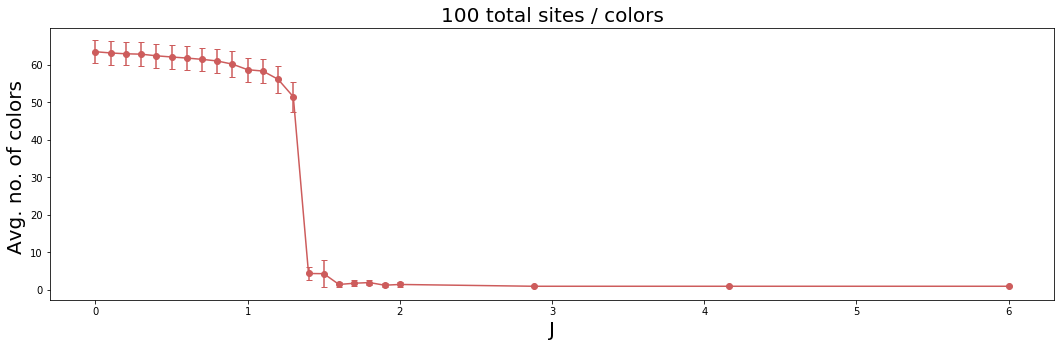

In [72]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (10, 100, Js=Js, gamma=0, alpha=0)

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
experiment_full_interaction (20, 400, Js=Js, gamma=0, alpha=0)

## J (edges / neighbor interaction) with multiple Gamma

In [95]:
def plot_multiple (params, avg_c, std_c, params2, param_name, param_name2):
    f = plt.figure(figsize=(18, 5)) 
    
    for i in range(len(params)):
        plt.errorbar(params[i], avg_c[i], std_c[i], linestyle='solid', capsize=3, marker='o',
                     label=(str(param_name2)+" = "+str(params2[i])) )

    plt.title(str(N*N) + " total sites / colors", fontsize=20)
    plt.xlabel(param_name, fontsize=20)
    plt.ylabel("Avg. no. of colors ", fontsize=20)
    plt.legend()
    plt.savefig("Simulation_all_interaction/avg_std_("
                + str(N)+ "," + str(N*N) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_.png", format="png")

    plt.show()

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[ 3 24 11  8 16]
 [ 6 16 14  8  5]
 [ 3 20 10  8 23]
 [11 17  4  5 10]
 [ 7 25 12 20  4]]
equilibration step: 0
1 num. cols: 18.0 avg. sites per col: 1.3888888888888888
101 num. cols: 16.07920792079208 avg. sites per col: 1.5685386305615894
Final configuration:
[[19  2  1 11  7]
 [19 19 19 10 22]
 [ 6  1 15 13 21]
 [ 1  5 12  9  4]
 [ 2 10  8  8 13]]
Final averages: 16.085714285714285 1.5676472118312006
Final stds: 1.4807609736971359 0.14721877500082262
--

1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.8217821782178216 avg. sites per col: 8.019212635549266
Final configuration:
[[7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 3.723809523809524 8.54705215419501
Final stds: 1.7861650224792627 4.407095472117363
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[ 1  2 23 24 24]
 [ 2 23 23 20  6]
 [ 1  1 11 12  4]
 [ 4  9  3 25 24]
 [ 7 10 23  2  7]]
equilibration step: 0
1 num. cols: 3.0 avg. sites per col: 8.333333333333334
101 num. cols: 2.405940594059406 avg. sites per col: 12.39686468646865
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 2.3523809523809525 12.87698412698413
Final stds: 0.8616811075251445 6.523645384719202
------------------------------------------------------------------

1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.990099009900991 avg. sites per col: 1.951103521793679
Final configuration:
[[15  7 22 22 25]
 [18  5 10 23 14]
 [17 19 25  8 22]
 [23 17 16 18 13]
 [ 6 17  6  5 25]]
Final averages: 13.00952380952381 1.9475938394005623
Final stds: 1.533717786762971 0.221369470213648
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[ 5 25 10 20 15]
 [11  2  2  2 25]
 [16 12 13  8  5]
 [24 14  3  2 12]
 [18 24  6  2 11]]
equilibration step: 0
1 num. cols: 12.0 avg. sites per col: 2.0833333333333335
101 num. cols: 13.366336633663366 avg. sites per col: 1.8950057780503333
Final configuration:
[[12 25  4 19 13]
 [15  3  3 24 19]
 [ 3 21 24 22 24]
 [16 25 15 25 12]
 [10  4 20  7  6]]
Final averages: 13.457142857142857 1.883330954759527
Final stds: 1.5183234577813054 0.2292238033739

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.702970297029703 avg. sites per col: 16.46039603960396
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.6761904761904762 16.785714285714285
Final stds: 0.5254519704431895 6.098213559459856
------------------------------------------------------------------------------------------------------------------------

15  - param: 1.5
edge probabilities: [0.95021293 0.04978707]
Initial configuration
[[22  2  3  8 17]
 [ 5  2 10 15 17]
 [ 6  7  5 24 13]
 [19 10 17 13 20]
 [17  9 14 12 16]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.108910891089109 avg. sites per col: 23.638613861386137
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.1047619047619048 23.69047619047619
Final stds: 0.3062463845869243 3.8280798073365543
---------------------------------------------------------------------------

1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.752475247524753 avg. sites per col: 2.5945719571957193
Final configuration:
[[10 11 17  9 22]
 [ 1 16 11 16 17]
 [ 5 16  5  6 22]
 [ 9  7 11 11 16]
 [ 7  7  5 11  9]]
Final averages: 9.761904761904763 2.5909692159692157
Final stds: 1.0647942749998998 0.2777131293081378
------------------------------------------------------------------------------------------------------------------------

4  - param: 0.4
edge probabilities: [0.55067104 0.44932896]
Initial configuration
[[17 14 18 20  6]
 [24 10  3 21 12]
 [13 10 11 11 21]
 [21 22 11 19  1]
 [25 20 19 16 24]]
equilibration step: 0
1 num. cols: 8.0 avg. sites per col: 3.125
101 num. cols: 10.049504950495049 avg. sites per col: 2.5329456022525343
Final configuration:
[[ 3 25 15  6 23]
 [23  6  3 15 21]
 [13 13 13 13 24]
 [ 9  2 11 21 15]
 [25 25 13 24 11]]
Final averages: 10.085714285714285 2.5230325230325232
Final stds: 1.3317677883838723 0.33977604425691016
-------

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]
 [22 22 22 22 22]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[ 1 16  1  8 13]
 [17 25 20 10  7]
 [ 8  6  1  2  7]
 [12 24  9 12 22]
 [24  5 25 16 20]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]
 [10 10 10 10 10]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

18  - param: 1.8
edge probabilities: [0.97267628 0.02732372]
Initial confi

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]
 [7 7 7 7 7]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

7  - param: 0.7
edge probabilities: [0.75340304 0.24659696]
Initial configuration
[[ 3 14 14 17 14]
 [14 21  3 13  6]
 [15  3  5 23 15]
 [ 9 19 12  5 20]
 [ 1  1 17  1  5]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]
 [24 24 24 24 24]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 8 11 22 19 15]


1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

22  - param: 4.16
edge probabilities: [9.99756404e-01 2.43595864e-04]
Initial configuration
[[ 7 23 18  2  5]
 [ 7 23 10  2 15]
 [ 7 14  2 13 18]
 [16 20  7 11  8]
 [19  1 14 14 23]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]
 [17 17 17 17 17]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 5.0 avg. sites per col: 5.0
Final configuration:
[[10 22 22 10 22]
 [14 10  2 14 14]
 [13 10 13  2 13]
 [14 14 10 13 14]
 [22 22 14  2  2]]

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide



Final averages: 5.0 5.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[ 9 22 24 24 12]
 [16 22  5 11 24]
 [11 13  3  6 14]
 [18 10  9  4 10]
 [ 1  8  1 17 21]]
equilibration step: 0
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 5.0 avg. sites per col: 5.0
Final configuration:
[[ 6 23 23 10 10]
 [25  6 23 25 10]
 [10 23 10  6  6]
 [10 25 10  6  6]
 [23 10  5 10 23]]
Final averages: 5.0 5.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[20 18 22  2 19]
 [18 20 15 21 15]
 [13  5 22 13  4]
 [23 12  3 19 13]
 [21  2 18 22 16]]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 

1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]
 [19 19 19 19 19]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 1 11 14 12 21]
 [ 9  3 20 14  7]
 [16  9 11 22  2]
 [18  6  4 12  9]
 [15  1  8 18 21]]
equilibration step: 0
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]
 [25 25 25 25 25]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configu

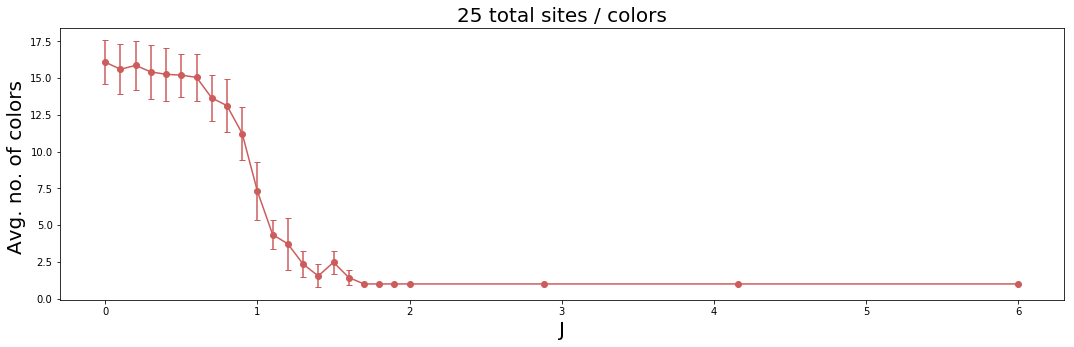

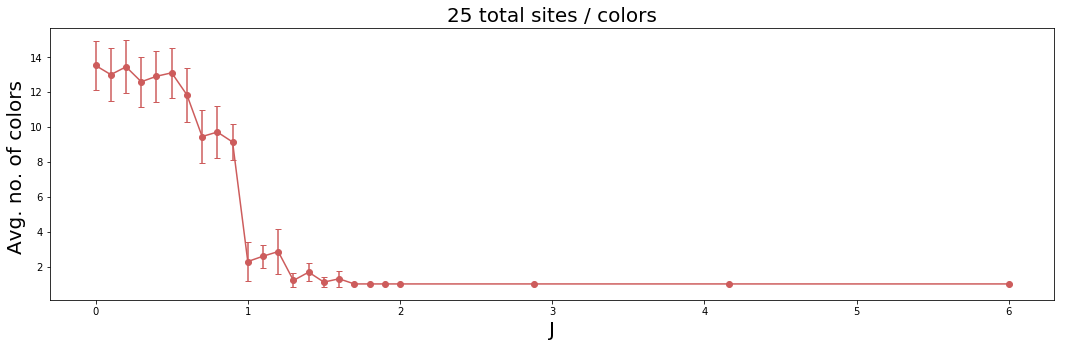

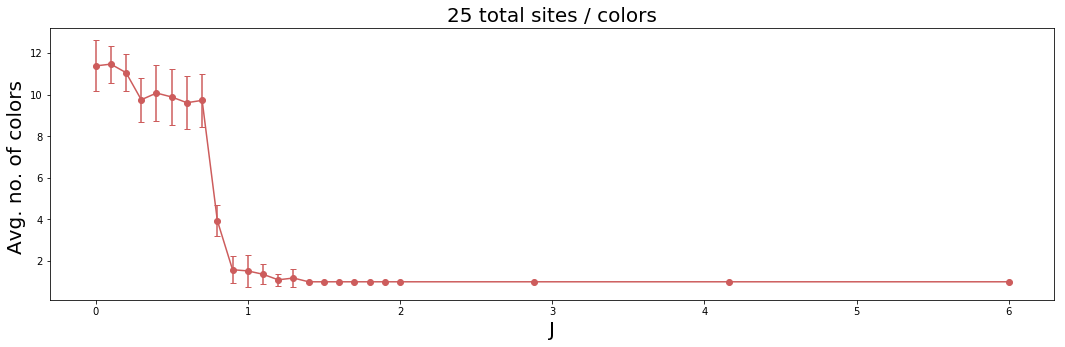

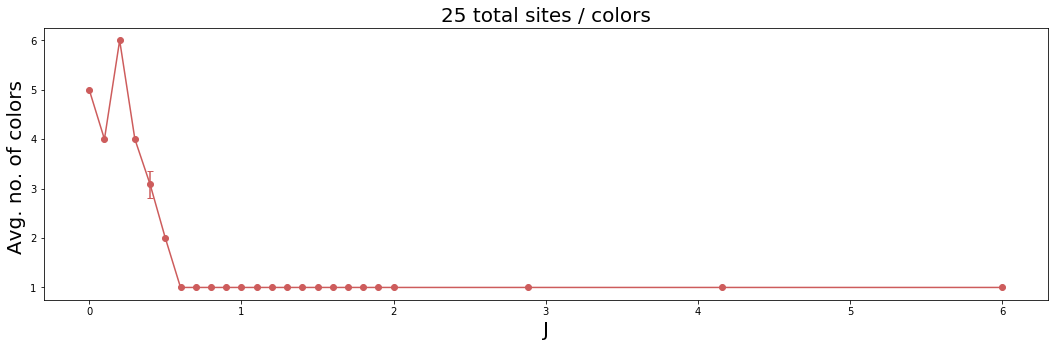

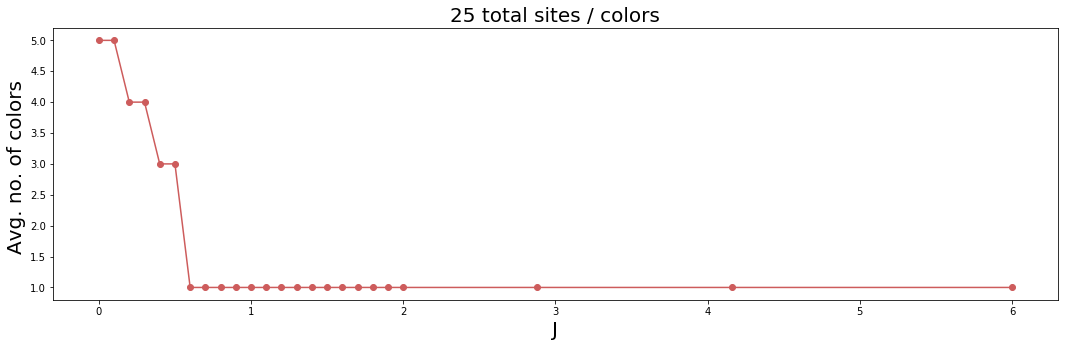

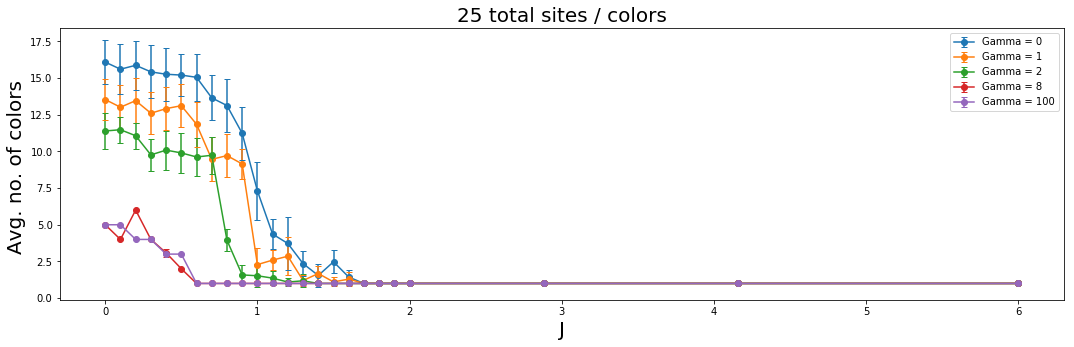

In [97]:
eq_steps = 505          #  number of MC sweeps for equilibration
mc_steps = 105          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 0 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[20  7 11 21  7]
 [ 4 12 21  7  1]
 [21 19 19  4  7]
 [13 24 23  5 14]
 [24  7  9 20 22]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 14.0 avg. sites per col: 1.7857142857142858
101 num. cols: 16.04950495049505 avg. sites per col: 1.571403644634187
201 num. cols: 16.074626865671643 avg. sites per col: 1.5697821072890397
301 num. cols: 15.9568

401 num. cols: 14.86783042394015 avg. sites per col: 1.7036991028555295
501 num. cols: 14.920159680638722 avg. sites per col: 1.697178335171701
601 num. cols: 14.910149750415973 avg. sites per col: 1.6987727143997289
701 num. cols: 14.954350927246791 avg. sites per col: 1.6934641112258912
801 num. cols: 14.945068664169789 avg. sites per col: 1.6950471508809504
901 num. cols: 14.93007769145394 avg. sites per col: 1.6970678972715774
1001 num. cols: 14.883116883116884 avg. sites per col: 1.7022733090720839
Final configuration:
[[12 25 10  5  9]
 [ 3 18  5 18 10]
 [21 12  2 13 17]
 [ 2 14 10 17 22]
 [23 11  9  7  4]]
Final averages: 14.891542288557213 1.7014182460528524
Final stds: 1.6990421970966938 0.20081633938509655
------------------------------------------------------------------------------------------------------------------------

6  - param: 0.6
edge probabilities: [0.69880579 0.30119421]
Initial configuration
[[12  6 21  3  6]
 [ 7 24 19 24 14]
 [ 6 14 20  7  2]
 [ 3 21 18  1 21

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 6.0 avg. sites per col: 4.166666666666667
101 num. cols: 5.287128712871287 avg. sites per col: 5.629723686654377
201 num. cols: 6.497512437810945 avg. sites per col: 4.506216213305763
301 num. cols: 5.840531561461794 avg. sites per col: 5.170778142123652
401 num. cols: 5.72568578553616 avg. sites per col: 5.126285116933499
501 num. cols: 6.429141716566866 avg. sites per col: 4.661036595916847
601 num. cols: 6.422628951747088 avg. sites per col: 4.687692599506248
701 num. cols: 6.1455064194008555 avg. sites per col: 4.968995084009352
801 num. cols: 6.390761548064919 avg. sites per col: 4.807876528382153
901 num. cols: 6.665926748057713 avg. sites per col: 4.606360697509428
1001 num. cols: 7.104895104895105 avg. sites per col: 4.381545028398171
Final configuration:
[[ 2 12 17 24 23]
 [ 2 19 20 25 23]
 [ 2 16 20 23 23]
 [16  3 23 23 23]
 [16 23 23 23 23

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.1293532338308458 avg. sites per col: 23.383084577114428
301 num. cols: 1.212624584717608 avg. sites per col: 22.3421926910299
401 num. cols: 1.2668329177057356 avg. sites per col: 21.706151288445557
501 num. cols: 1.4830339321357286 avg. sites per col: 20.088988689288144
601 num. cols: 1.4026622296173046 avg. sites per col: 20.906128674431546
701 num. cols: 1.3851640513552068 avg. sites per col: 20.99084640989067
801 num. cols: 1.3433208489388264 avg. sites per col: 21.4133374947982
901 num. cols: 1.3052164261931187 avg. sites per col: 21.81141324454313
1001 num. cols: 1.2747252747252746 avg. sites per col: 22.129953379953403
Final configuration:
[[18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.27363184

GAMMA: 1 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 3.77513454e-11]
Trying params: [0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
 1.4  1.5  1.6  1.7  1.8  1.9  2.   2.88 4.16 6.  ]
0  - param: 0.0
edge probabilities: [0. 1.]
Initial configuration
[[24  7  7  9  5]
 [21  3  2 19  8]
 [ 8 18  6  9 20]
 [22 14 10 16 19]
 [ 5  3  2  3  9]]
equilibration step: 0
equilibration step: 1000
equilibration step

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 13.0 avg. sites per col: 1.9230769230769231
101 num. cols: 12.089108910891088 avg. sites per col: 2.0940624282208455
201 num. cols: 11.950248756218905 avg. sites per col: 2.113573270289683
301 num. cols: 12.375415282392026 avg. sites per col: 2.0497356664788735
401 num. cols: 12.239401496259351 avg. sites per col: 2.0775042093987386
501 num. cols: 12.165668662674651 avg. sites per col: 2.0949856651248
601 num. cols: 12.299500831946755 avg. sites per col: 2.072164368153892
701 num. cols: 12.315263908701855 avg. sites per col: 2.067979289202115
801 num. cols: 12.319600499375781 avg. sites per col: 2.0681416043830576
901 num. cols: 12.233074361820199 avg. sites per col: 2.0828652090077187
1001 num. cols: 12.222777222777223 avg. sites per col: 2.085268266678758
Final configuration:
[[ 7  5 13 14 18]
 [17  5  5 20 21]
 [ 5 10  5 17  7]
 [ 7  1  9  9 18]
 [ 9  1 18 20 18]]
Final averages: 12.2248756218905

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 2.3267326732673266 avg. sites per col: 13.345709570957093
201 num. cols: 2.2487562189054726 avg. sites per col: 13.061774461028197
301 num. cols: 2.548172757475083 avg. sites per col: 11.940753045404229
401 num. cols: 2.5885286783042396 avg. sites per col: 11.54984562403515
501 num. cols: 2.3013972055888225 avg. sites per col: 13.876889078984886
601 num. cols: 2.3643926788685525 avg. sites per col: 14.06932559490796
701 num. cols: 2.4465049928673324 avg. sites per col: 13.791706292597887
801 num. cols: 2.3957553058676653 avg. sites per col: 14.15426896934389
901 num. cols: 2.3895671476137625 avg. sites per col: 14.20373967196944
1001 num. cols: 2.387612387612388 avg. sites per col: 14.087648462648504
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0042796005706134 avg. sites per col: 24.946504992867332
801 num. cols: 1.00374531835206 avg. sites per col: 24.95318352059925
901 num. cols: 1.0033296337402886 avg. sites per col: 24.958379578246394
1001 num. cols: 1.002997002997003 avg. sites per col: 24.962537462537462
Final configuration:
[[18 18 18 18 18]
 [22 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]
 [18 18 18 18 18]]
Final averages: 1.0049751243781095 24.937810945273633
Final stds: 0.07035888370015399 0.8794860462519246
---------------------------------------------------------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 11.0 avg. sites per col: 2.272727272727273
101 num. cols: 9.227722772277227 avg. sites per col: 2.736273627362733
201 num. cols: 10.348258706467663 avg. sites per col: 2.4713898594495527
301 num. cols: 10.631229235880399 avg. sites per col: 2.394458623694498
401 num. cols: 10.82294264339152 avg. sites per col: 2.349282748285236
501 num. cols: 11.013972055888223 avg. sites per col: 2.3136585636585574
601 num. cols: 11.05657237936772 avg. sites per col: 2.3070073298858578
701 num. cols: 11.119828815977176 avg. sites per col: 2.290771520443406
801 num. cols: 11.184769038701623 avg. sites per col: 2.276933082176513
901 num. cols: 11.146503884572697 avg. sites per col: 2.281090779980887
1001 num. cols: 11.188811188811188 avg. sites per col: 2.27001783320465
Final configuration:
[[20  6 23 11 21]
 [17 19 12 20 21]
 [17 19 16 12  7]
 [ 7  6 12 19 19]
 [20  

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 2.7777777777777777
101 num. cols: 9.148514851485148 avg. sites per col: 2.754025402540252
201 num. cols: 8.82587064676617 avg. sites per col: 2.891722014856338
301 num. cols: 8.564784053156146 avg. sites per col: 3.034721369438976
401 num. cols: 8.71072319201995 avg. sites per col: 2.965434572354775
501 num. cols: 8.7125748502994 avg. sites per col: 2.954163130061343
601 num. cols: 8.820299500831947 avg. sites per col: 2.9174028966042376
701 num. cols: 8.89586305278174 avg. sites per col: 2.8939558816520408
801 num. cols: 9.012484394506867 avg. sites per col: 2.8613353285638077
901 num. cols: 8.90899001109878 avg. sites per col: 2.8939241175645285
1001 num. cols: 8.724275724275724 avg. sites per col: 2.9639854539954444
Final configuration:
[[ 1 23 23 23  2]
 [ 1 23 23 23  6]
 [ 6  2 23 23  4]
 [25  8 25  8  8]
 [25  5  2  2  1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.1782178217821782 avg. sites per col: 22.77227722772277
201 num. cols: 1.472636815920398 avg. sites per col: 19.46517412935324
301 num. cols: 1.3322259136212624 avg. sites per col: 21.096345514950173
401 num. cols: 1.2493765586034913 avg. sites per col: 22.069825436408983
501 num. cols: 1.2574850299401197 avg. sites per col: 21.9311377245509
601 num. cols: 1.2146422628951747 avg. sites per col: 22.44176372712147
701 num. cols: 1.1840228245363766 avg. sites per col: 22.80670470756063
801 num. cols: 1.2172284644194757 avg. sites per col: 22.419891801914268
901 num. cols: 1.2097669256381798 avg. sites per col: 22.49815020347761
1001 num. cols: 1.1888111888111887 avg. sites per col: 22.748085248085243
Final configuration:
[[14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]
 [14 14 14 14 14]

301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

19  - param: 1.9
edge probabilities: [0.97762923 0.02237077]
Initial configuration
[[14  6 23 25 19]
 [11  8  6 16  7]
 [ 5 24 23 16 15]
 [16 23 16 21  5]
 [15  3  4 21 16]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites 

201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.095577746077033 avg. sites per col: 6.130527817403709
801 num. cols: 4.2084893882646695 avg. sites per col: 5.989388264669164
901 num. cols: 4.296337402885682 avg. sites per col: 5.879578246392897
1001 num. cols: 4.3666333666333665 avg. sites per col: 5.791708291708292
Final configuration:
[[17 22  6  6  6]
 [17 14  6  6 22]
 [ 6 22 22  2 14]
 [22  6 22  2  2]
 [17 22 22  2 17]]
Final averages: 4.369154228855721 5.788557213930348
Final stds: 0.4825757807574465 0.6032197259468082
------------------------------------------------------------------------------------------------------------------------

2  - param: 0.2
edge probabilities: [0.32967995 0.67032005]
Initial configuration
[[17 15  2 19 19]
 [10  1  2 18 15]
 [ 6 21 21  8 20]
 [24  6 23  3 23]
 [2

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]
 [16 16 16 16 16]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[24 21 18 23  7]
 [ 6 17 25 24

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]
 [9 9 9 9 9]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

17  - param: 1.7
edge probabilities: [0.96662673 0.03337327]
Initial configuration
[[18  8  6  8 22]
 [11 14 15  9 19]
 [ 8  3 13  9 23]
 

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 4.0 avg. sites per col: 6.25
201 num. cols: 4.0 avg. sites per col: 6.25
301 num. cols: 4.0 avg. sites per col: 6.25
401 num. cols: 4.0 avg. sites per col: 6.25
501 num. cols: 4.0 avg. sites per col: 6.25
601 num. cols: 4.0 avg. sites per col: 6.25
701 num. cols: 4.0 avg. sites per col: 6.25
801 num. cols: 4.0 avg. sites per col: 6.25
901 num. cols: 4.0 avg. sites per col: 6.25
1001 num. cols: 4.0 avg. sites per col: 6.25
Final configuration:
[[ 2 18  3  3 18]
 [18 18 18  3 11]
 [ 3 11  2 18  2]
 [18 18 18  3 11]
 [ 3 11 11 18 11]]
Final averages: 4.0 6.25
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[13 10 10 25 13]
 [ 9  1 10  9

401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]
 [15 15 15 15 15]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

8  - param: 0.8
edge probabilities: [0.79810348 0.20189652]
Initial configuration
[[ 1  8  6  6  2]
 [ 2  7 23 10 15]
 [ 8 17  8 17 12]
 [10 16 24 10 12]
 [ 5 25 23 19 25]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 nu

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]
 [6 6 6 6 6]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

16  - param: 1.6
edge probabilities: [0.9592378 0.0407622]
Initial configuration
[[ 7 12 16  6 11]
 [22 10 23 11  3]
 [ 1 20 12 20  8]
 [1

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]
 [2 2 2 2 2]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------



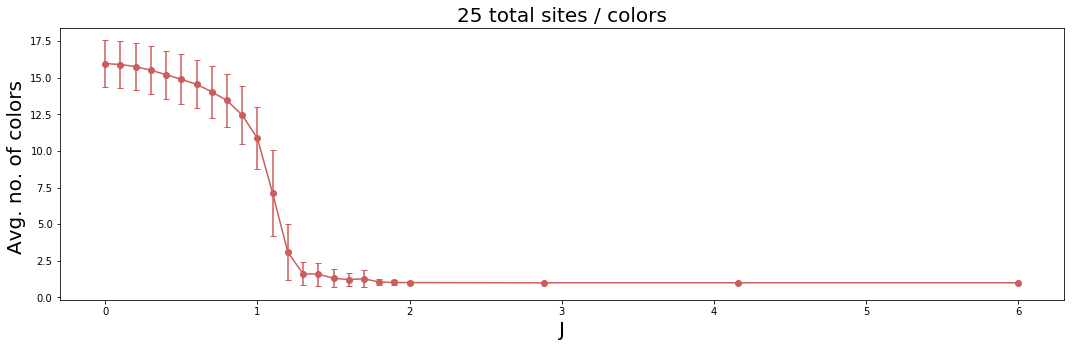

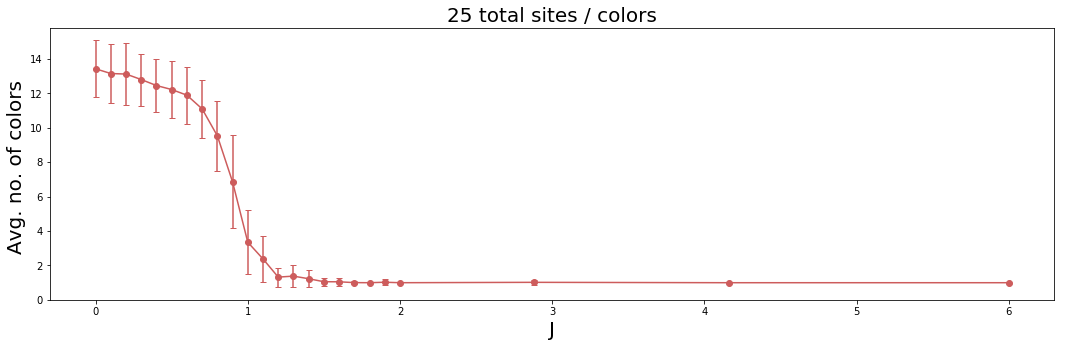

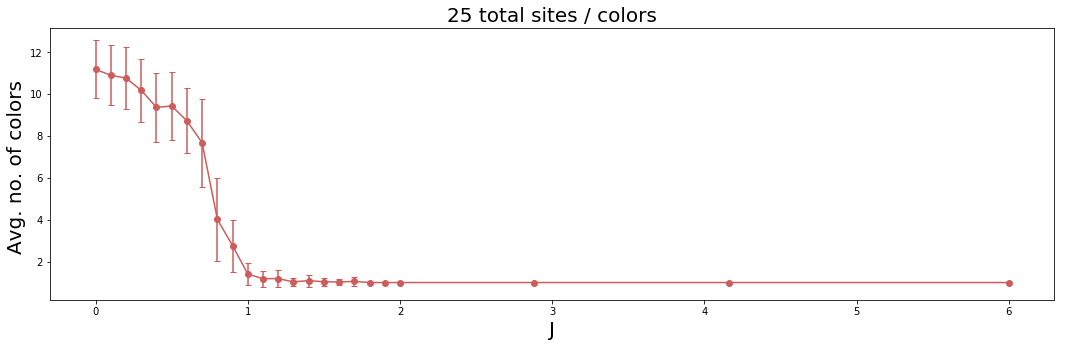

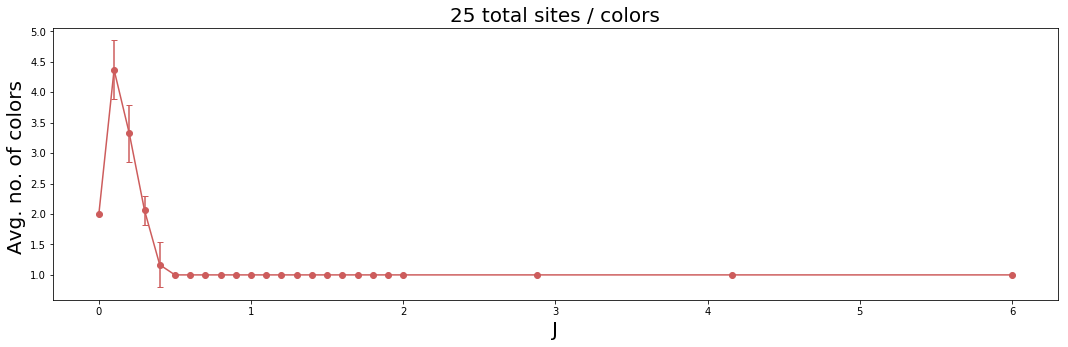

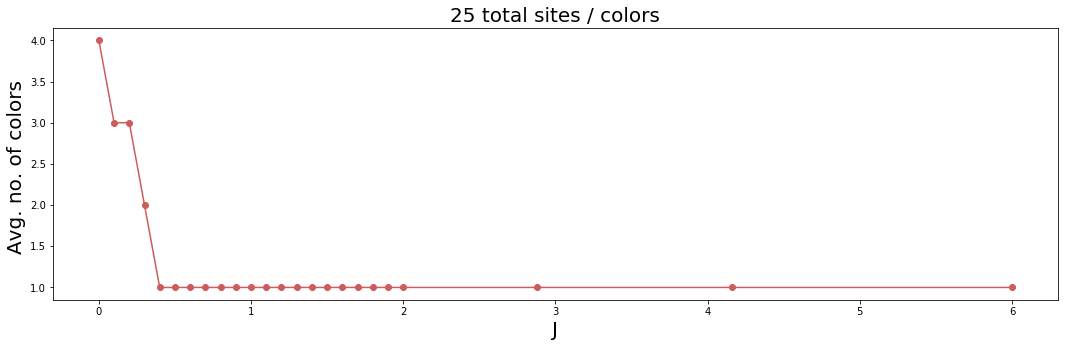

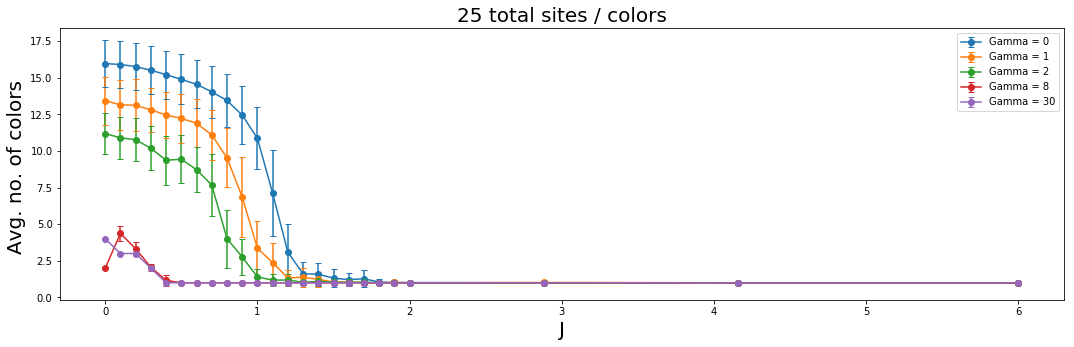

In [99]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 5

k=0
ngamma = 5
params, avg_c, std_c = [], [], []
gammas = [0,1,2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 2 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.43743112e-31
 4.65205714e-32 6.29587471e-33 8.52053987e-34 1.15312968e-34
 1.56059131e-35 2.11203068e-36 2.85832270e-37 3.86831912e-3

1 num. cols: 15.0 avg. sites per col: 3.2666666666666666
Final configuration:
[[10 10 10 28 12 27 11]
 [10 10 10 37 37 37 18]
 [10 10 30 44 29  7 18]
 [10 10 10 27 27 24 24]
 [10 10 27 27 27 29  1]
 [40 18 27 27 27 10 10]
 [27 43  1 27 13 37 37]]
Final averages: 15.266666666666667 3.212222222222222
Final stds: 0.4422166387140533 0.09028589707078585
------------------------------------------------------------------------------------------------------------------------

11  - param: 1.1
edge probabilities: [0.88919684 0.11080316]
Initial configuration
[[37 24 35 18 12 23 34]
 [31 40 39 11 11  7 33]
 [48 29 41 36 20 48 20]
 [20 23  8  2 48 33 38]
 [11 17  9 14  5 15 39]
 [20 44 29 16 40 34  2]
 [46  3 18 30  8  9 34]]
equilibration step: 0
1 num. cols: 13.0 avg. sites per col: 3.769230769230769
Final configuration:
[[45 45 45 47 47 47 47]
 [42  2 45 45 47 47 47]
 [29  2 45 45 47 47 19]
 [29  2 45 45 47 47 19]
 [ 4  4  4 37 47 26 25]
 [25 25 45 45 26 26 42]
 [42 42 45 45 12 42 42]]
Final a

equilibration step: 0
1 num. cols: 3.0 avg. sites per col: 16.333333333333332
Final configuration:
[[ 6  6  2  2  2  2  2]
 [ 6  2  2  2  2  2  2]
 [ 6  2  2  2  2  2  2]
 [ 6  2  2  2  2  2  2]
 [ 2  2  2  2  2  2  2]
 [ 2  2  2  2  2  2  2]
 [ 2 25 25  2  2  2  2]]
Final averages: 3.0 16.333333333333336
Final stds: 0.0 3.552713678800501e-15
------------------------------------------------------------------------------------------------------------------------

23  - param: 6.0
edge probabilities: [9.99993856e-01 6.14421235e-06]
Initial configuration
[[33 14 14  7  1 43 25]
 [14 18 14 12  7 13  4]
 [13  8 26 36 26  4 30]
 [ 7  1 40  8 48 49 41]
 [42 35 24 25 41 25 19]
 [32 42  8 30 34 33 23]
 [ 8 29 10 19 18 13  4]]
equilibration step: 0
1 num. cols: 4.0 avg. sites per col: 12.25
Final configuration:
[[ 5 15 15 15 15 15 15]
 [ 5  5 15 12 12 15 15]
 [ 5  5 15 12 12 15 15]
 [ 5  5  5 12 12 12 12]
 [ 5  5  5 12 12 12 12]
 [ 5  5  5  5  5 12 11]
 [ 5  5  5  5 12 12 12]]
Final averages: 4.

1 num. cols: 18.0 avg. sites per col: 2.7222222222222223
Final configuration:
[[31 33 47 23 18 21  3]
 [31 31 33 32 26  1 44]
 [19 29 23 23 27  1 26]
 [19 27 23 23 21 47 47]
 [46 27 26 19 18 18 18]
 [14 21 21 32 26 26 29]
 [14  3 18 46 46  2 47]]
Final averages: 17.866666666666667 2.743572984749455
Final stds: 0.33993463423951903 0.054433977378223586
------------------------------------------------------------------------------------------------------------------------

9  - param: 0.9
edge probabilities: [0.83470111 0.16529889]
Initial configuration
[[36 34 16 31 46 20 45]
 [36 23 39 23  1 30  4]
 [17 30  5 49 46 12 40]
 [ 9 33 10 28 34 32 26]
 [23 27 49 17 39 40 13]
 [22 31 22 20  3 14 22]
 [34 18 48 34 22 17 22]]
equilibration step: 0
1 num. cols: 15.0 avg. sites per col: 3.2666666666666666
Final configuration:
[[34 34 34 19 33 33 25]
 [34 34 34 34 12 40 10]
 [24 34 34 34  6  6 10]
 [24 17 34 34 33  6 25]
 [33 19 34 34 24 25 40]
 [22 22 22 33 33 22 40]
 [11 22 22 20 11 10 11]]
Final

equilibration step: 0
1 num. cols: 6.0 avg. sites per col: 8.166666666666666
Final configuration:
[[34 34 34 34 34 34 34]
 [34 34 34 34 34 34 34]
 [34 34 34 34 34 34 34]
 [34 32 34 34 34 34 34]
 [34 34 34 34 34 34 34]
 [34 34 34 34 34 34 34]
 [34 34 36 34 34 34 34]]
Final averages: 4.333333333333333 11.814444444444446
Final stds: 0.8692269873603531 2.5802301553002946
------------------------------------------------------------------------------------------------------------------------

21  - param: 2.88
edge probabilities: [0.99684889 0.00315111]
Initial configuration
[[44 10 28 25  5 13 12]
 [28 38 34 14  9 12 36]
 [13 38 47 33 32 30 21]
 [21 18 21 22  9 46 12]
 [ 1 29 10  8 15 47 29]
 [ 6 15 32 37 12 10 49]
 [ 8 19  1 19 45 40 42]]
equilibration step: 0
1 num. cols: 2.0 avg. sites per col: 24.5
Final configuration:
[[24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]
 [24 24 24 24 24 24 24]]
F

C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Oscar\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in less


1 num. cols: 19.0 avg. sites per col: 2.5789473684210527
Final configuration:
[[12 45 32 24  2 26 15]
 [42  9 40 33 26 26 43]
 [ 2 36 33 26 14 46 36]
 [24  9 15 24 43 44 11]
 [12 11  9 14 43 43 39]
 [12 45 40 11 42 32  2]
 [11 45 14 34 43 33 34]]
Final averages: 19.0 2.5789473684210527
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

1  - param: 0.1
edge probabilities: [0.18126925 0.81873075]
Initial configuration
[[ 7 44  5 31 16 21 49]
 [30 30 36 30 40  7 34]
 [44 25 27 36 47 16 37]
 [45 13 36 39 10 17 48]
 [15 32  5 23 26  5  5]
 [39 43 13 29 45 22 14]
 [ 9 49  6 10 28 10 43]]
equilibration step: 0
1 num. cols: 19.0 avg. sites per col: 2.5789473684210527
Final configuration:
[[41 42 33 36 34 31 22]
 [16  2 22 41 31 16 28]
 [16 34 22 28 33 16 34]
 [46 16 12 44 42 31 42]
 [30 13 46 27 27 11 12]
 [33 28 36 13 30 36 27]
 [17 33 31 42 34 44 30]]
Final averages: 18.666666666666668 2.62670565302144

1 num. cols: 5.0 avg. sites per col: 9.8
Final configuration:
[[33 33 33 33  7 16 33]
 [33 33 33 33 33 33 33]
 [33 33 33 33 33 33 33]
 [33 33 33 33 33 33 33]
 [33 33 33 33 33 33 33]
 [33 33 33 33 33 33 33]
 [33 33  7 28 31 33 33]]
Final averages: 5.0 9.8
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

13  - param: 1.3
edge probabilities: [0.92572642 0.07427358]
Initial configuration
[[32  4 23 48 27  6 21]
 [29  1  6 31  6 43 29]
 [39 13 28  7 14 17 49]
 [31  7 43 14 40 26 25]
 [47  4  1 37  8 25 30]
 [10 16 34 14 18 15 46]
 [20  4 47 21 25  5 31]]
equilibration step: 0
1 num. cols: 8.0 avg. sites per col: 6.125
Final configuration:
[[23  8  8  8  8  8  8]
 [ 8  8  8  8  8  8  8]
 [ 8  8  8  8  8  8  8]
 [ 8  8  8  8  8  8  8]
 [ 8  8  8  8  8  8  8]
 [ 8  8  8  8  8  8  8]
 [ 8  8  8  8  8  8 33]]
Final averages: 5.866666666666666 9.24
Final stds: 1.746106780494506 3.078968682553973
---------

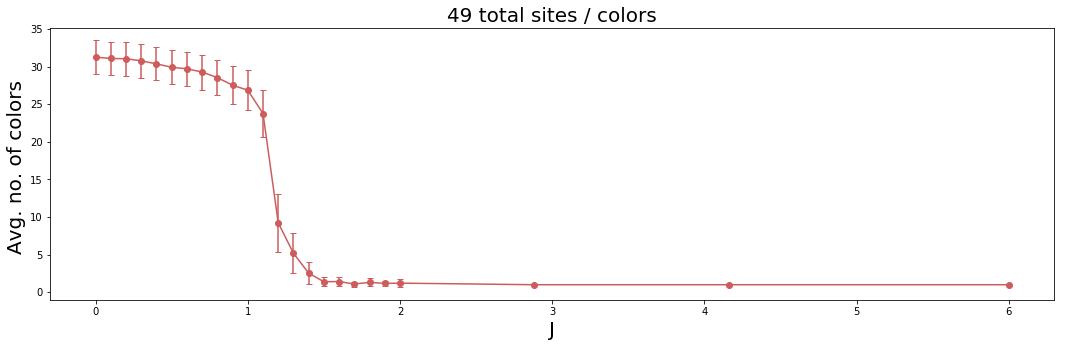

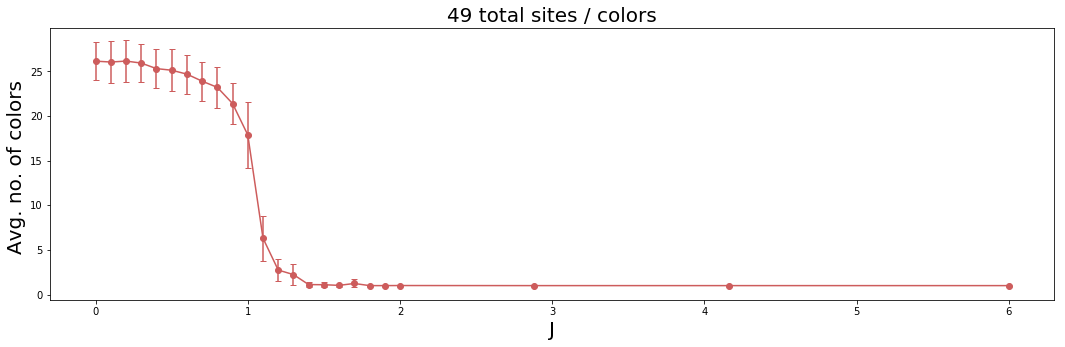

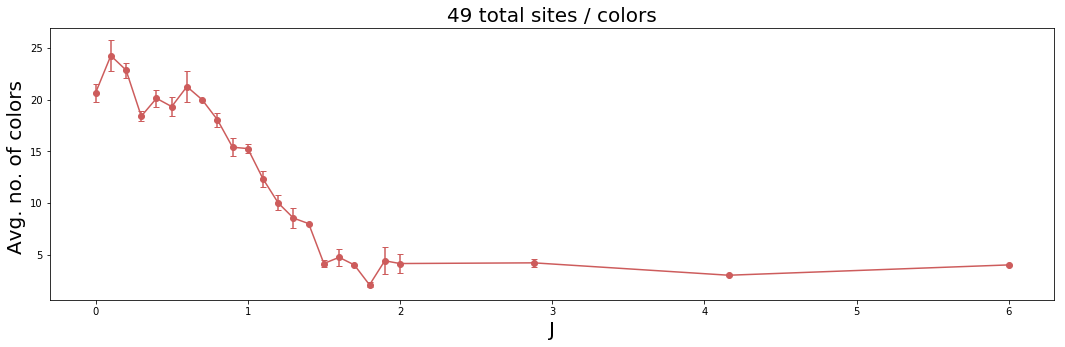

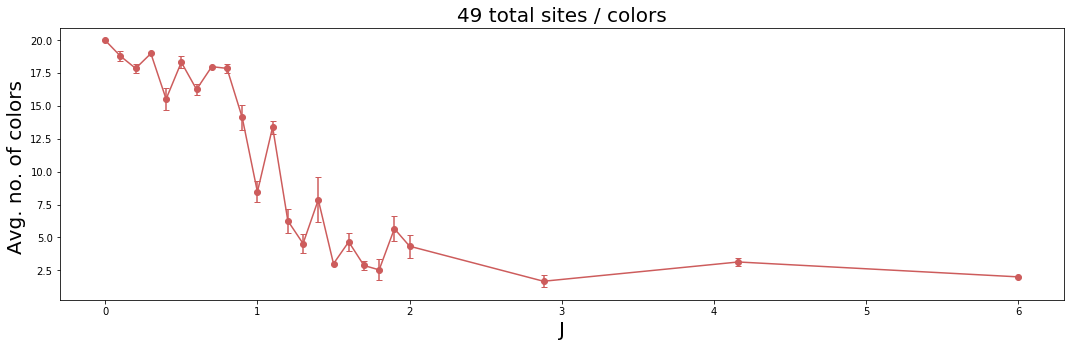

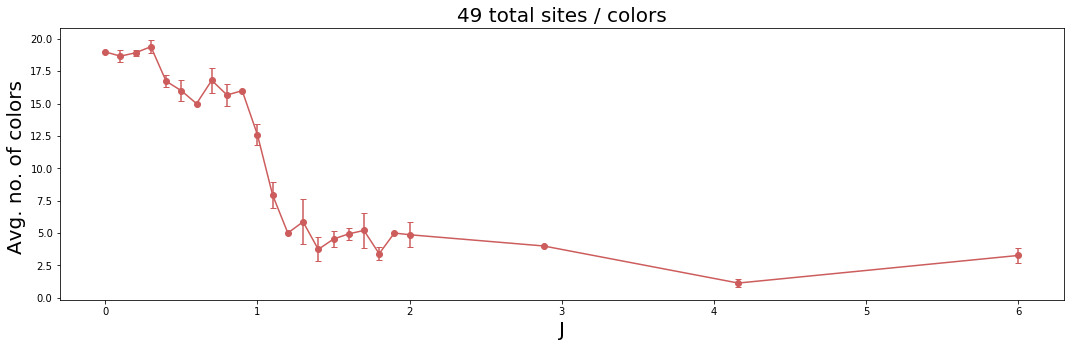

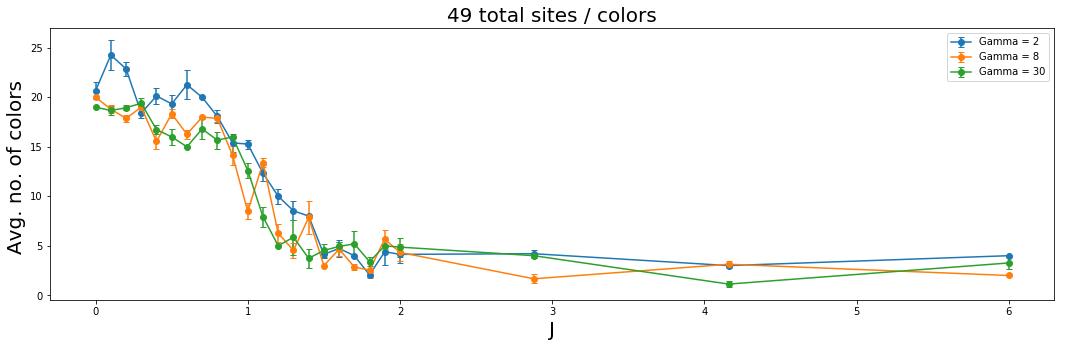

In [101]:
eq_steps = 55          #  number of MC sweeps for equilibration
mc_steps = 15          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 7

k=0
ngamma = 3
params, avg_c, std_c = [], [], []
gammas = [2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 7

k=0
ngamma = 3
params, avg_c, std_c = [], [], []
gammas = [2,8,30]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

GAMMA: 2 ####################################################################################################
edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.43743112e-31
 4.65205714e-32 6.29587471e-33 8.52053987e-34 1.15312968e-34
 1.56059131e-35 2.11203068e-36 2.85832270e-37 3.86831912e-3

In [ ]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nJ = 20
Js = np.linspace(0, 2, num=nJ, endpoint=False)
Js = np.append(Js, np.geomspace(2, 6, num=4)).round(decimals=2)
N = 10

k=0
ngamma = 6
params, avg_c, std_c = [], [], []
gammas = [0,1,2,4,8,16]
for gamma in gammas:
    print("GAMMA:",gamma,"#"*100)
    tp, ta, ts = experiment_full_interaction (N, N*N, Js=Js, gamma=gamma, alpha=0)
    params.append(tp)
    avg_c.append(ta)
    std_c.append(ts)

plot_multiple (params, avg_c, std_c, gammas, "J", "Gamma")

## Alpha (sites / field interaction)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 1.]
Trying params: [ 0.    0.3   0.6   0.9   1.2   1.5   1.8   2.1   2.4   2.7   3.    3.3
  3.6   3.9   4.2   4.5   4.8   5.1   5.4   5.7   6.    7.3   8.88 10.81
 13.15 16.  ]
0  - param: 0.0
site probabilities: [0. 0. 0. 1.]
Initial configuration
[[4 4]
 [3 4]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 1.3333333333333333
101 num. cols: 2.762376237623762 avg. sites per col: 1.5775577557755782
201 num. cols: 2.800995024875622 avg. sites per col: 1.5389718076285241
301 num. cols: 2.7906976744186047 avg. sites per col: 1.5404208194905833
401 num. cols: 2.7955112219451372 avg. sites per col: 1.535328345802161
501 num. cols: 2.784431137724551 avg. sites per col: 1.5375914836992723
601 num. cols: 2.7853577371048255 avg. sites per col: 1.5330005546311773
701 

equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 1.4059405940594059 avg. sites per col: 3.227722772277228
201 num. cols: 1.4129353233830846 avg. sites per col: 3.2006633499170807
301 num. cols: 1.4053156146179402 avg. sites per col: 3.207087486157253
401 num. cols: 1.4937655860349128 avg. sites per col: 3.0523690773067327
501 num. cols: 1.4790419161676647 avg. sites per col: 3.0765136393878905
601 num. cols: 1.4875207986688852 avg. sites per col: 3.062673322240709
701 num. cols: 1.4950071326676178 avg. sites per col: 3.046124583927722
801 num. cols: 1.4719101123595506 avg. sites per col: 3.087806908031627
901 num. cols: 1.4661487236403996 avg. sites per col: 3.0972992970773214
1001 num. cols: 1.4955044955044956 avg. sites per col: 3.0532800532800546
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.4945273631840796 3.055058043117746
Final stds: 0.5635882732887277 1.0270299961508564
-------------------

601 num. cols: 1.0748752079866888 avg. sites per col: 3.8502495840266224
701 num. cols: 1.0770328102710414 avg. sites per col: 3.8459343794579173
801 num. cols: 1.087390761548065 avg. sites per col: 3.82521847690387
901 num. cols: 1.0854605993340734 avg. sites per col: 3.8290788013318533
1001 num. cols: 1.0799200799200799 avg. sites per col: 3.8401598401598402
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0796019900497513 3.8407960199004973
Final stds: 0.27067603002458596 0.5413520600491719
------------------------------------------------------------------------------------------------------------------------

13  - param: 3.9
site probabilities: [9.79758089e-01 1.98321765e-02 4.01441160e-04 8.29381916e-06]
Initial configuration
[[1 2]
 [4 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 4.0
101 num. cols: 1.00990099009901 avg. sites per col

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 2.0
101 num. cols: 1.0594059405940595 avg. sites per col: 3.881188118811881
201 num. cols: 1.0298507462686568 avg. sites per col: 3.9402985074626864
301 num. cols: 1.0365448504983388 avg. sites per col: 3.9269102990033224
401 num. cols: 1.027431421446384 avg. sites per col: 3.945137157107232
501 num. cols: 1.0219560878243512 avg. sites per col: 3.9560878243512976
601 num. cols: 1.0183028286189684 avg. sites per col: 3.9633943427620633
701 num. cols: 1.0185449358059915 avg. sites per col: 3.962910128388017
801 num. cols: 1.0162297128589264 avg. sites per col: 3.9675405742821472
901 num. cols: 1.0144284128745837 avg. sites per col: 3.9711431742508325
1001 num. cols: 1.014985014985015 avg. sites per col: 3.97002997002997
Final configuration:
[[1 1]
 [1 1]]
Final averages: 1.0149253731343284 3.970149253731343
Final stds: 0.1212543

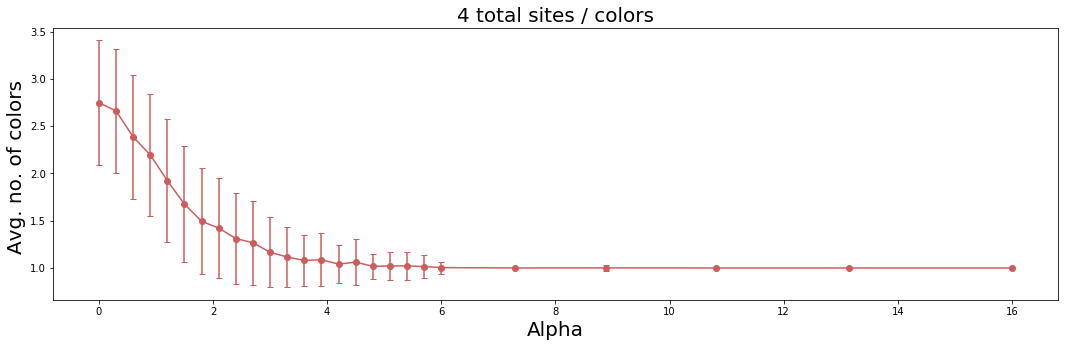

In [50]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nalphas = 20
alphas = np.linspace(0, 6, num=nJ, endpoint=False)
alphas = np.append(alphas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (2, 4, alphas=alphas, gamma=0, J=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.3   0.6   0.9   1.2   1.5   1.8   2.1   2.4   2.7   3.    3.3
  3.6   3.9   4.2   4.5   4.8   5.1   5.4   5.7   6.    7.3   8.88 10.81
 13.15 16.  ]
0  - param: 0.0
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[8 7 7]
 [3 7 4]
 [9 2 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 7.0 avg. sites per col: 1.2857142857142858
101 num. cols: 6.03960396039604 avg. sites per col: 1.5443422913719946
201 num. cols: 5.970149253731344 avg. sites per col: 1.5551705756929646
301 num. cols: 5.906976744186046 avg. sites per col: 1.5732558139534896
401 num. cols: 5.905236907730673 avg. sites per col: 1.5719540434627717
501 num. cols: 5.896207584830339 avg. sites per col: 1.5768035357855714
601 num. cols: 5.8901

Final configuration:
[[1 1 1]
 [1 1 2]
 [1 1 1]]
Final averages: 2.193034825870647 4.568208955223881
Final stds: 0.6560482051978936 1.7303773424841442
------------------------------------------------------------------------------------------------------------------------

6  - param: 1.8
site probabilities: [8.34701112e-01 1.37975166e-01 2.28071415e-02 3.76999513e-03
 6.23176004e-04 1.03010301e-04 1.70274882e-05 2.81462486e-06
 5.57390369e-07]
Initial configuration
[[6 3 4]
 [7 3 9]
 [7 9 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 3.0
101 num. cols: 1.8415841584158417 avg. sites per col: 5.50990099009901
201 num. cols: 1.8159203980099503 avg. sites per col: 5.597014925373134
301 num. cols: 1.8338870431893688 avg. sites per col: 5.526578073089701
401 num. cols: 1.8478802992518704 avg. sites per col: 5.502493765586035
501 num. cols: 1.9061876247

801 num. cols: 1.2634207240948814 avg. sites per col: 7.822097378277154
901 num. cols: 1.2597114317425082 avg. sites per col: 7.83795782463929
1001 num. cols: 1.2637362637362637 avg. sites per col: 7.819180819180819
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.263681592039801 7.8194029850746265
Final stds: 0.44512212881595153 1.9841339932763289
------------------------------------------------------------------------------------------------------------------------

12  - param: 3.6
site probabilities: [9.72676278e-01 2.65771366e-02 7.26186305e-04 1.98421130e-05
 5.42160390e-07 1.48138400e-08 4.04769253e-10 1.10598027e-11
 3.10684024e-13]
Initial configuration
[[4 7 1]
 [9 7 5]
 [7 2 8]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 4.5
101 num. cols: 1.2574257425742574 avg. sites per col: 7.841584158415841
201 num. cols: 1.258706

501 num. cols: 1.0499001996007984 avg. sites per col: 8.775449101796408
601 num. cols: 1.0449251247920133 avg. sites per col: 8.79783693843594
701 num. cols: 1.042796005706134 avg. sites per col: 8.807417974322396
801 num. cols: 1.0499375780274656 avg. sites per col: 8.775280898876405
901 num. cols: 1.048834628190899 avg. sites per col: 8.780244173140954
1001 num. cols: 1.055944055944056 avg. sites per col: 8.748251748251748
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0567164179104478 8.744776119402985
Final stds: 0.23129994779475246 1.0408497650763862
------------------------------------------------------------------------------------------------------------------------

18  - param: 5.4
site probabilities: [9.95483419e-01 4.49618144e-03 2.03073674e-05 9.17198686e-08
 4.14260211e-10 1.87103977e-12 8.45070258e-15 3.81682822e-17
 1.73172283e-19]
Initial configuration
[[5 4 2]
 [1 9 9]
 [4 5 7]]
equilibration step: 0
equilibration step: 1000
equilibration step: 200

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 9.0
101 num. cols: 1.0 avg. sites per col: 9.0
201 num. cols: 1.0 avg. sites per col: 9.0
301 num. cols: 1.0 avg. sites per col: 9.0
401 num. cols: 1.0 avg. sites per col: 9.0
501 num. cols: 1.0 avg. sites per col: 9.0
601 num. cols: 1.0 avg. sites per col: 9.0
701 num. cols: 1.0 avg. sites per col: 9.0
801 num. cols: 1.0 avg. sites per col: 9.0
901 num. cols: 1.0 avg. sites per col: 9.0
1001 num. cols: 1.0 avg. sites per col: 9.0
Final configuration:
[[1 1 1]
 [1 1 1]
 [1 1 1]]
Final averages: 1.0 9.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

25  - param: 16.0
site probabilities: [9.99999887e-01 1.12535162e-07 1.26641641e-14 1.42516392e-21
 1.60381071e-28 1.80485118e-35 2.03109243e-42 2.28569342e-49
 2.57220937e-56]
Initial con

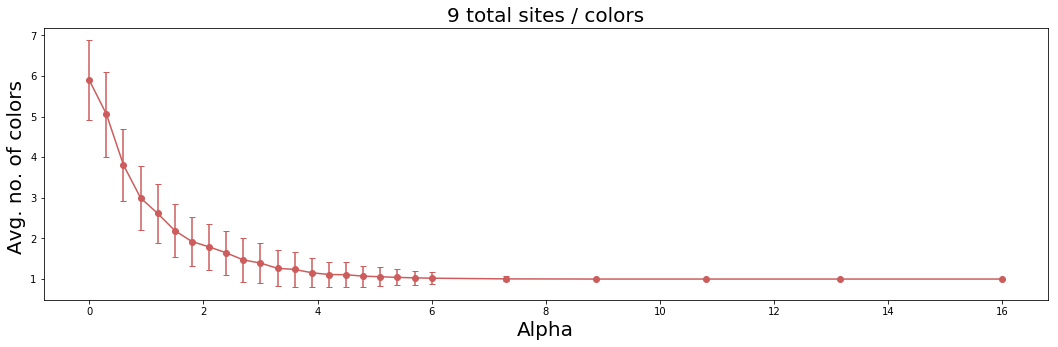

In [51]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nalphas = 20
alphas = np.linspace(0, 6, num=nJ, endpoint=False)
alphas = np.append(alphas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (3, 9, alphas=alphas, gamma=0, J=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Trying params: [ 0.    0.3   0.6   0.9   1.2   1.5   1.8   2.1   2.4   2.7   3.    3.3
  3.6   3.9   4.2   4.5   4.8   5.1   5.4   5.7   6.    7.3   8.88 10.81
 13.15 16.  ]
0  - param: 0.0
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Initial configuration
[[ 7  6 14  2]
 [ 4  7  9  8]
 [12  8  2  1]
 [16 12  7 12]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 9.0 avg. sites per col: 1.7777777777777777
101 num. cols: 10.178217821782178 avg. sites per col: 1.5968014383855955
201 num. cols: 10.228855721393035 avg. sites per col: 1.5880775940477434
301 num. cols: 10.23920265780731 avg. sites per col: 1.5877908728407073
401 num. cols: 10.261845386533667 avg. sites per col: 1.5822672201

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 8.0
101 num. cols: 2.4554455445544554 avg. sites per col: 7.036303630363038
201 num. cols: 2.4676616915422884 avg. sites per col: 6.985074626865668
301 num. cols: 2.478405315614618 avg. sites per col: 6.883720930232546
401 num. cols: 2.5286783042394014 avg. sites per col: 6.753117206982554
501 num. cols: 2.5169660678642716 avg. sites per col: 6.8396540252827895
601 num. cols: 2.529118136439268 avg. sites per col: 6.810870770937355
701 num. cols: 2.542082738944365 avg. sites per col: 6.7693770803613935
801 num. cols: 2.5555555555555554 avg. sites per col: 6.736579275905105
901 num. cols: 2.5571587125416206 avg. sites per col: 6.721420643729162
1001 num. cols: 2.5534465534465536 avg. sites per col: 6.725274725274685
Final configuration:
[[2 1 1 1]
 [2 1 1 1]
 [1 1 1 2]
 [1 1 1 3]]
Final averages: 2.553233830845771 6.725041459369

501 num. cols: 1.6447105788423153 avg. sites per col: 11.033932135728541
601 num. cols: 1.642262895174709 avg. sites per col: 11.048252911813641
701 num. cols: 1.6476462196861625 avg. sites per col: 11.009034712315735
801 num. cols: 1.637952559300874 avg. sites per col: 11.082813150228876
901 num. cols: 1.6270810210876803 avg. sites per col: 11.155012948575655
1001 num. cols: 1.6183816183816184 avg. sites per col: 11.223443223443223
Final configuration:
[[1 1 1 1]
 [1 1 2 1]
 [1 1 1 1]
 [1 1 1 1]]
Final averages: 1.617910447761194 11.22653399668325
Final stds: 0.5475205186552882 4.03824765153998
------------------------------------------------------------------------------------------------------------------------

11  - param: 3.3
site probabilities: [9.63116833e-01 3.55227994e-02 1.31019336e-03 4.83240809e-05
 1.78234516e-06 6.57385350e-08 2.42464539e-09 8.94286019e-11
 3.29841009e-12 1.21655812e-13 4.48705167e-15 1.65496678e-16
 6.10404167e-18 2.25136391e-19 8.30374319e-21 3.1799709

1001 num. cols: 1.1728271728271729 avg. sites per col: 14.617382617382617
Final configuration:
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Final averages: 1.172139303482587 14.622885572139303
Final stds: 0.37750147506879606 3.0200118005503684
------------------------------------------------------------------------------------------------------------------------

16  - param: 4.8
site probabilities: [9.91770253e-01 8.16201831e-03 6.71713461e-05 5.52803188e-07
 4.54943040e-09 3.74406614e-11 3.08127173e-13 2.53580869e-15
 2.08690641e-17 1.71747119e-19 1.41343534e-21 1.16322153e-23
 9.57301899e-26 7.87835248e-28 6.48368480e-30 5.38018616e-32]
Initial configuration
[[ 5 16  7 13]
 [16 12 16  9]
 [ 4 14  2 16]
 [12  2  8  9]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.1386138613861385 avg. sites per col: 14.891089108910892
201 num

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 16.0
101 num. cols: 1.0 avg. sites per col: 16.0
201 num. cols: 1.0099502487562189 avg. sites per col: 15.92039800995025
301 num. cols: 1.0066445182724253 avg. sites per col: 15.946843853820598
401 num. cols: 1.0049875311720697 avg. sites per col: 15.960099750623442
501 num. cols: 1.0219560878243512 avg. sites per col: 15.82435129740519
601 num. cols: 1.0183028286189684 avg. sites per col: 15.853577371048253
701 num. cols: 1.0156918687589158 avg. sites per col: 15.874465049928673
801 num. cols: 1.013732833957553 avg. sites per col: 15.890137328339575
901 num. cols: 1.0122086570477247 avg. sites per col: 15.902330743618203
1001 num. cols: 1.014985014985015 avg. sites per col: 15.88011988011988
Final configuration:
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
Final averages: 1.0149253731343284 15.880597014925373
Final stds: 0.12

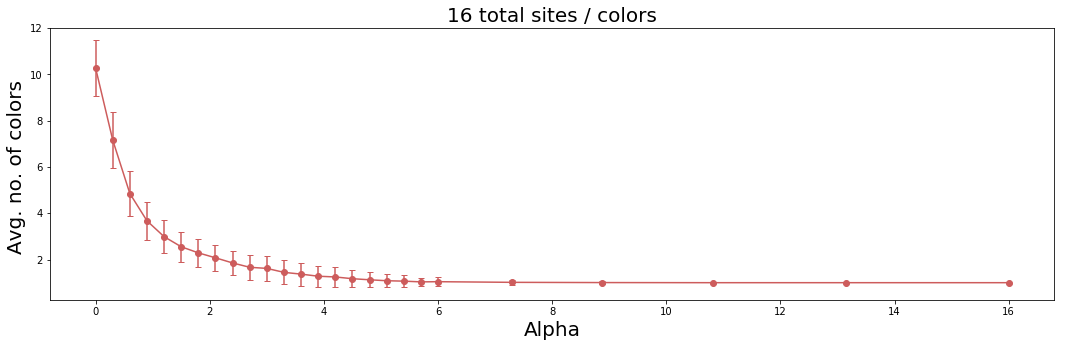

In [52]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nalphas = 20
alphas = np.linspace(0, 6, num=nJ, endpoint=False)
alphas = np.append(alphas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (4, 16, alphas=alphas, gamma=0, J=0)

edge probabilities: [0. 1.]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
lambda probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Trying params: [ 0.    0.3   0.6   0.9   1.2   1.5   1.8   2.1   2.4   2.7   3.    3.3
  3.6   3.9   4.2   4.5   4.8   5.1   5.4   5.7   6.    7.3   8.88 10.81
 13.15 16.  ]
0  - param: 0.0
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1.]
Initial configuration
[[16 16 11 17 22]
 [ 1 18 21 24 13]
 [21  1 10 20 16]
 [ 8 11 10 10 16]
 [ 4  5 20 20 14]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 16.0 avg. sites per col: 1.5625
101 num. cols: 16.297029702970296 avg. sites per col: 1.547207694691831
201 num. cols: 16.144278606965173 avg. sites per col: 1.562046888568307
301 num. cols: 16.056478405315616 avg

801 num. cols: 3.3782771535580522 avg. sites per col: 7.793383270911331
901 num. cols: 3.362930077691454 avg. sites per col: 7.826026637069877
1001 num. cols: 3.3386613386613386 avg. sites per col: 7.885031635031577
Final configuration:
[[2 2 1 1 3]
 [1 1 2 1 1]
 [2 2 4 1 1]
 [3 2 1 2 1]
 [1 1 2 3 2]]
Final averages: 3.3383084577114426 7.884742951907072
Final stds: 0.730960742000812 1.9001605799694359
------------------------------------------------------------------------------------------------------------------------

5  - param: 1.5
site probabilities: [7.76869840e-01 1.73343092e-01 3.86780718e-02 8.63024436e-03
 1.92566781e-03 4.29674566e-04 9.58733547e-05 2.13922370e-05
 4.77325327e-06 1.06505677e-06 2.37646287e-07 5.30260540e-08
 1.18317119e-08 2.64001178e-09 5.89066251e-10 1.31438447e-10
 2.93278817e-11 6.54393494e-12 1.46014925e-12 3.25803336e-13
 7.26965506e-14 1.62207930e-14 3.61934813e-15 8.07585729e-16
 2.31952283e-16]
Initial configuration
[[11  9 13  5  4]
 [16 23 25  5 

equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 1.891089108910891 avg. sites per col: 14.108910891089108
201 num. cols: 1.8407960199004976 avg. sites per col: 14.780265339966833
301 num. cols: 1.8538205980066444 avg. sites per col: 14.687153931339974
401 num. cols: 1.8902743142144638 avg. sites per col: 14.34954280964255
501 num. cols: 1.8862275449101797 avg. sites per col: 14.42531603459746
601 num. cols: 1.8785357737104826 avg. sites per col: 14.479339988907366
701 num. cols: 1.8730385164051355 avg. sites per col: 14.55361388492629
801 num. cols: 1.8651685393258426 avg. sites per col: 14.666562630045778
901 num. cols: 1.8557158712541622 avg. sites per col: 14.749815020347764
1001 num. cols: 1.8681318681318682 avg. sites per col: 14.616633366633375
Final configuration:
[[1 1 1 1 2]
 [1 1 1 1 1]
 [1 1 2 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.8686567164179104 14.608208955223887
Final stds: 0.4769958713247526 5.075038394200222
----------------

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.2079207920792079 avg. sites per col: 22.400990099009903
201 num. cols: 1.2139303482587065 avg. sites per col: 22.32587064676617
301 num. cols: 1.2591362126245846 avg. sites per col: 21.760797342192692
401 num. cols: 1.229426433915212 avg. sites per col: 22.13216957605985
501 num. cols: 1.2395209580838322 avg. sites per col: 22.005988023952096
601 num. cols: 1.2612312811980033 avg. sites per col: 21.73460898502496
701 num. cols: 1.2781740370898715 avg. sites per col: 21.55848787446505
801 num. cols: 1.2933832709113608 avg. sites per col: 21.363920099875156
901 num. cols: 1.2941176470588236 avg. sites per col: 21.351276359600444
1001 num. cols: 1.2997002997002998 avg. sites per col: 21.278721278721278
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.29

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0792079207920793 avg. sites per col: 24.00990099009901
201 num. cols: 1.0746268656716418 avg. sites per col: 24.067164179104477
301 num. cols: 1.069767441860465 avg. sites per col: 24.127906976744185
401 num. cols: 1.0698254364089776 avg. sites per col: 24.127182044887782
501 num. cols: 1.0658682634730539 avg. sites per col: 24.176646706586826
601 num. cols: 1.0615640599001663 avg. sites per col: 24.23044925124792
701 num. cols: 1.0699001426533523 avg. sites per col: 24.126248216833094
801 num. cols: 1.0699126092384519 avg. sites per col: 24.12609238451935
901 num. cols: 1.065482796892342 avg. sites per col: 24.181465038845726
1001 num. cols: 1.062937062937063 avg. sites per col: 24.213286713286713
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.062

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 1.0 avg. sites per col: 25.0
101 num. cols: 1.0 avg. sites per col: 25.0
201 num. cols: 1.0 avg. sites per col: 25.0
301 num. cols: 1.0 avg. sites per col: 25.0
401 num. cols: 1.0 avg. sites per col: 25.0
501 num. cols: 1.0 avg. sites per col: 25.0
601 num. cols: 1.0 avg. sites per col: 25.0
701 num. cols: 1.0 avg. sites per col: 25.0
801 num. cols: 1.0 avg. sites per col: 25.0
901 num. cols: 1.0 avg. sites per col: 25.0
1001 num. cols: 1.0 avg. sites per col: 25.0
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.0 25.0
Final stds: 0.0 0.0
------------------------------------------------------------------------------------------------------------------------

25  - param: 16.0
site probabilities: [9.99999887e-001 1.12535162e-007 1.26641641e-014 1.42516392e-021
 1.60381071e-028 1.80485118e-035 2.

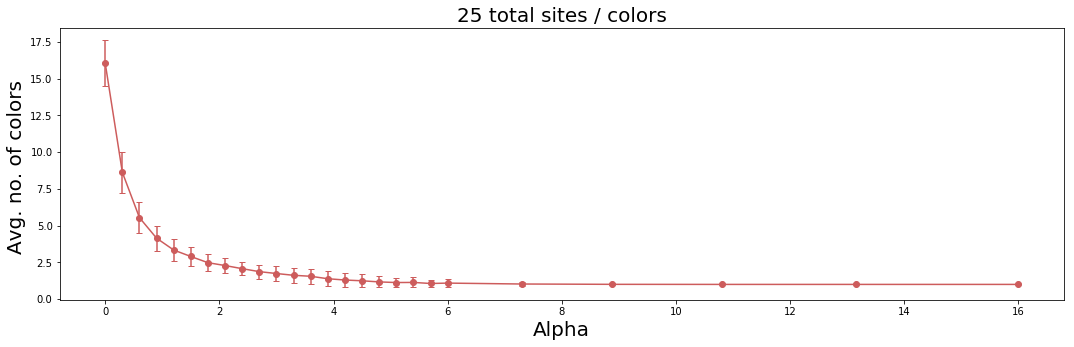

In [53]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
only_averages  = False
prt = False
nalphas = 20
alphas = np.linspace(0, 6, num=nJ, endpoint=False)
alphas = np.append(alphas, np.geomspace(6, 16, num=6)).round(decimals=2)
experiment_full_interaction (5, 25, alphas=alphas, gamma=0, J=0)